<a href="https://colab.research.google.com/github/mihhwiNick/DA_project/blob/huy/DA06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Thực hành các giải thuật phân loại cơ bản

##Import thư viện

In [2]:
import numpy as np #numerical computation
import pandas as pd #data wrangling
import matplotlib.pyplot as plt #plotting package
#Next line helps with rendering plots
%matplotlib inline
import matplotlib as mpl #add'l plotting functionality
mpl.rcParams['figure.dpi'] = 400 #high res figures
import graphviz #to visualize decision trees
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.preprocessing import LabelEncoder, StandardScaler

##Nạp dữ liệu

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')
fec = pd.read_csv('/content/gdrive/MyDrive/Dataset_Of_DA/diabetes_prediction_dataset.csv')
mushroom_data = pd.read_csv('/content/gdrive/MyDrive/Dataset_Of_DA/mushrooms.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##2.1.4. Xây dựng cây quyết định và rừng cây cho bộ dữ liệu Bệnh Tiểu Đường

**Xây dựng Cây Quyết Định**

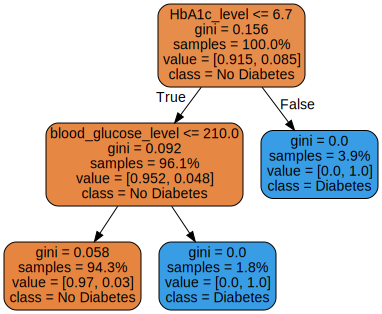

In [4]:
# Tiền xử lý dữ liệu
df_processed = fec.copy()

# Mã hóa các biến categorical
label_encoders = {}
categorical_columns = ['gender', 'smoking_history']

for col in categorical_columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le

# Định nghĩa features và target
features_response = ['gender', 'age', 'hypertension', 'heart_disease',
                    'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = \
train_test_split(df_processed[features_response[:-1]].values,
                df_processed['diabetes'].values,
                test_size=0.2, random_state=24,
                stratify=df_processed['diabetes'])  # Giữ tỷ lệ lớp cân bằng

# Tạo và huấn luyện cây quyết định
dt = tree.DecisionTreeClassifier(max_depth=2, random_state=24)
dt.fit(X_train, y_train)

# Visualize the decision tree
dot_data = tree.export_graphviz(dt,
                               out_file=None,
                               filled=True,
                               rounded=True,
                               feature_names=features_response[:-1],
                               proportion=True,
                               class_names=['No Diabetes', 'Diabetes'])

graph = graphviz.Source(dot_data)
graph

**Nhận xét:**
+ Mô hình cây quyết định cho thấy hai chỉ số quan trọng nhất trong việc dự đoán bệnh tiểu đường là HbA1c_level và blood_glucose_level. Điều kiện phân chia đầu tiên tại ngưỡng HbA1c_level ≤ 6.7 cho thấy đây là yếu tố then chốt trong chẩn đoán. Theo tiêu chuẩn chẩn đoán của Hiệp hội Đái tháo đường Hoa Kỳ (ADA), ngưỡng HbA1c ≥ 6.5% được sử dụng để chẩn đoán bệnh tiểu đường, trong khi giá trị từ 5.7% đến 6.4% được xem là tiền tiểu đường.
+ Đối với nhóm bệnh nhân có HbA1c_level ≤ 6.7 (chiếm 96.1% tổng mẫu), nguy cơ tiểu đường là rất thấp với chỉ 4.8% được chẩn đoán mắc bệnh. Trong khi đó, nhóm có HbA1c_level > 6.7 (3.9% tổng mẫu) được xác định là nhóm nguy cơ cao, và mô hình tiếp tục sử dụng blood_glucose_level ≤ 210.0 để tinh chỉnh phân loại. Đáng chú ý, tất cả bệnh nhân thuộc nhánh này đều được chẩn đoán tiểu đường, thể hiện khả năng dự đoán chính xác tuyệt đối cho các trường hợp rõ ràng.

**Tìm tham số tối ưu cho cây quyết định bằng GridSearchCV và vẽ biểu đồ đánh giá mô hình với các tham số khác nhau**

Fitting 4 folds for each of 7 candidates, totalling 28 fits


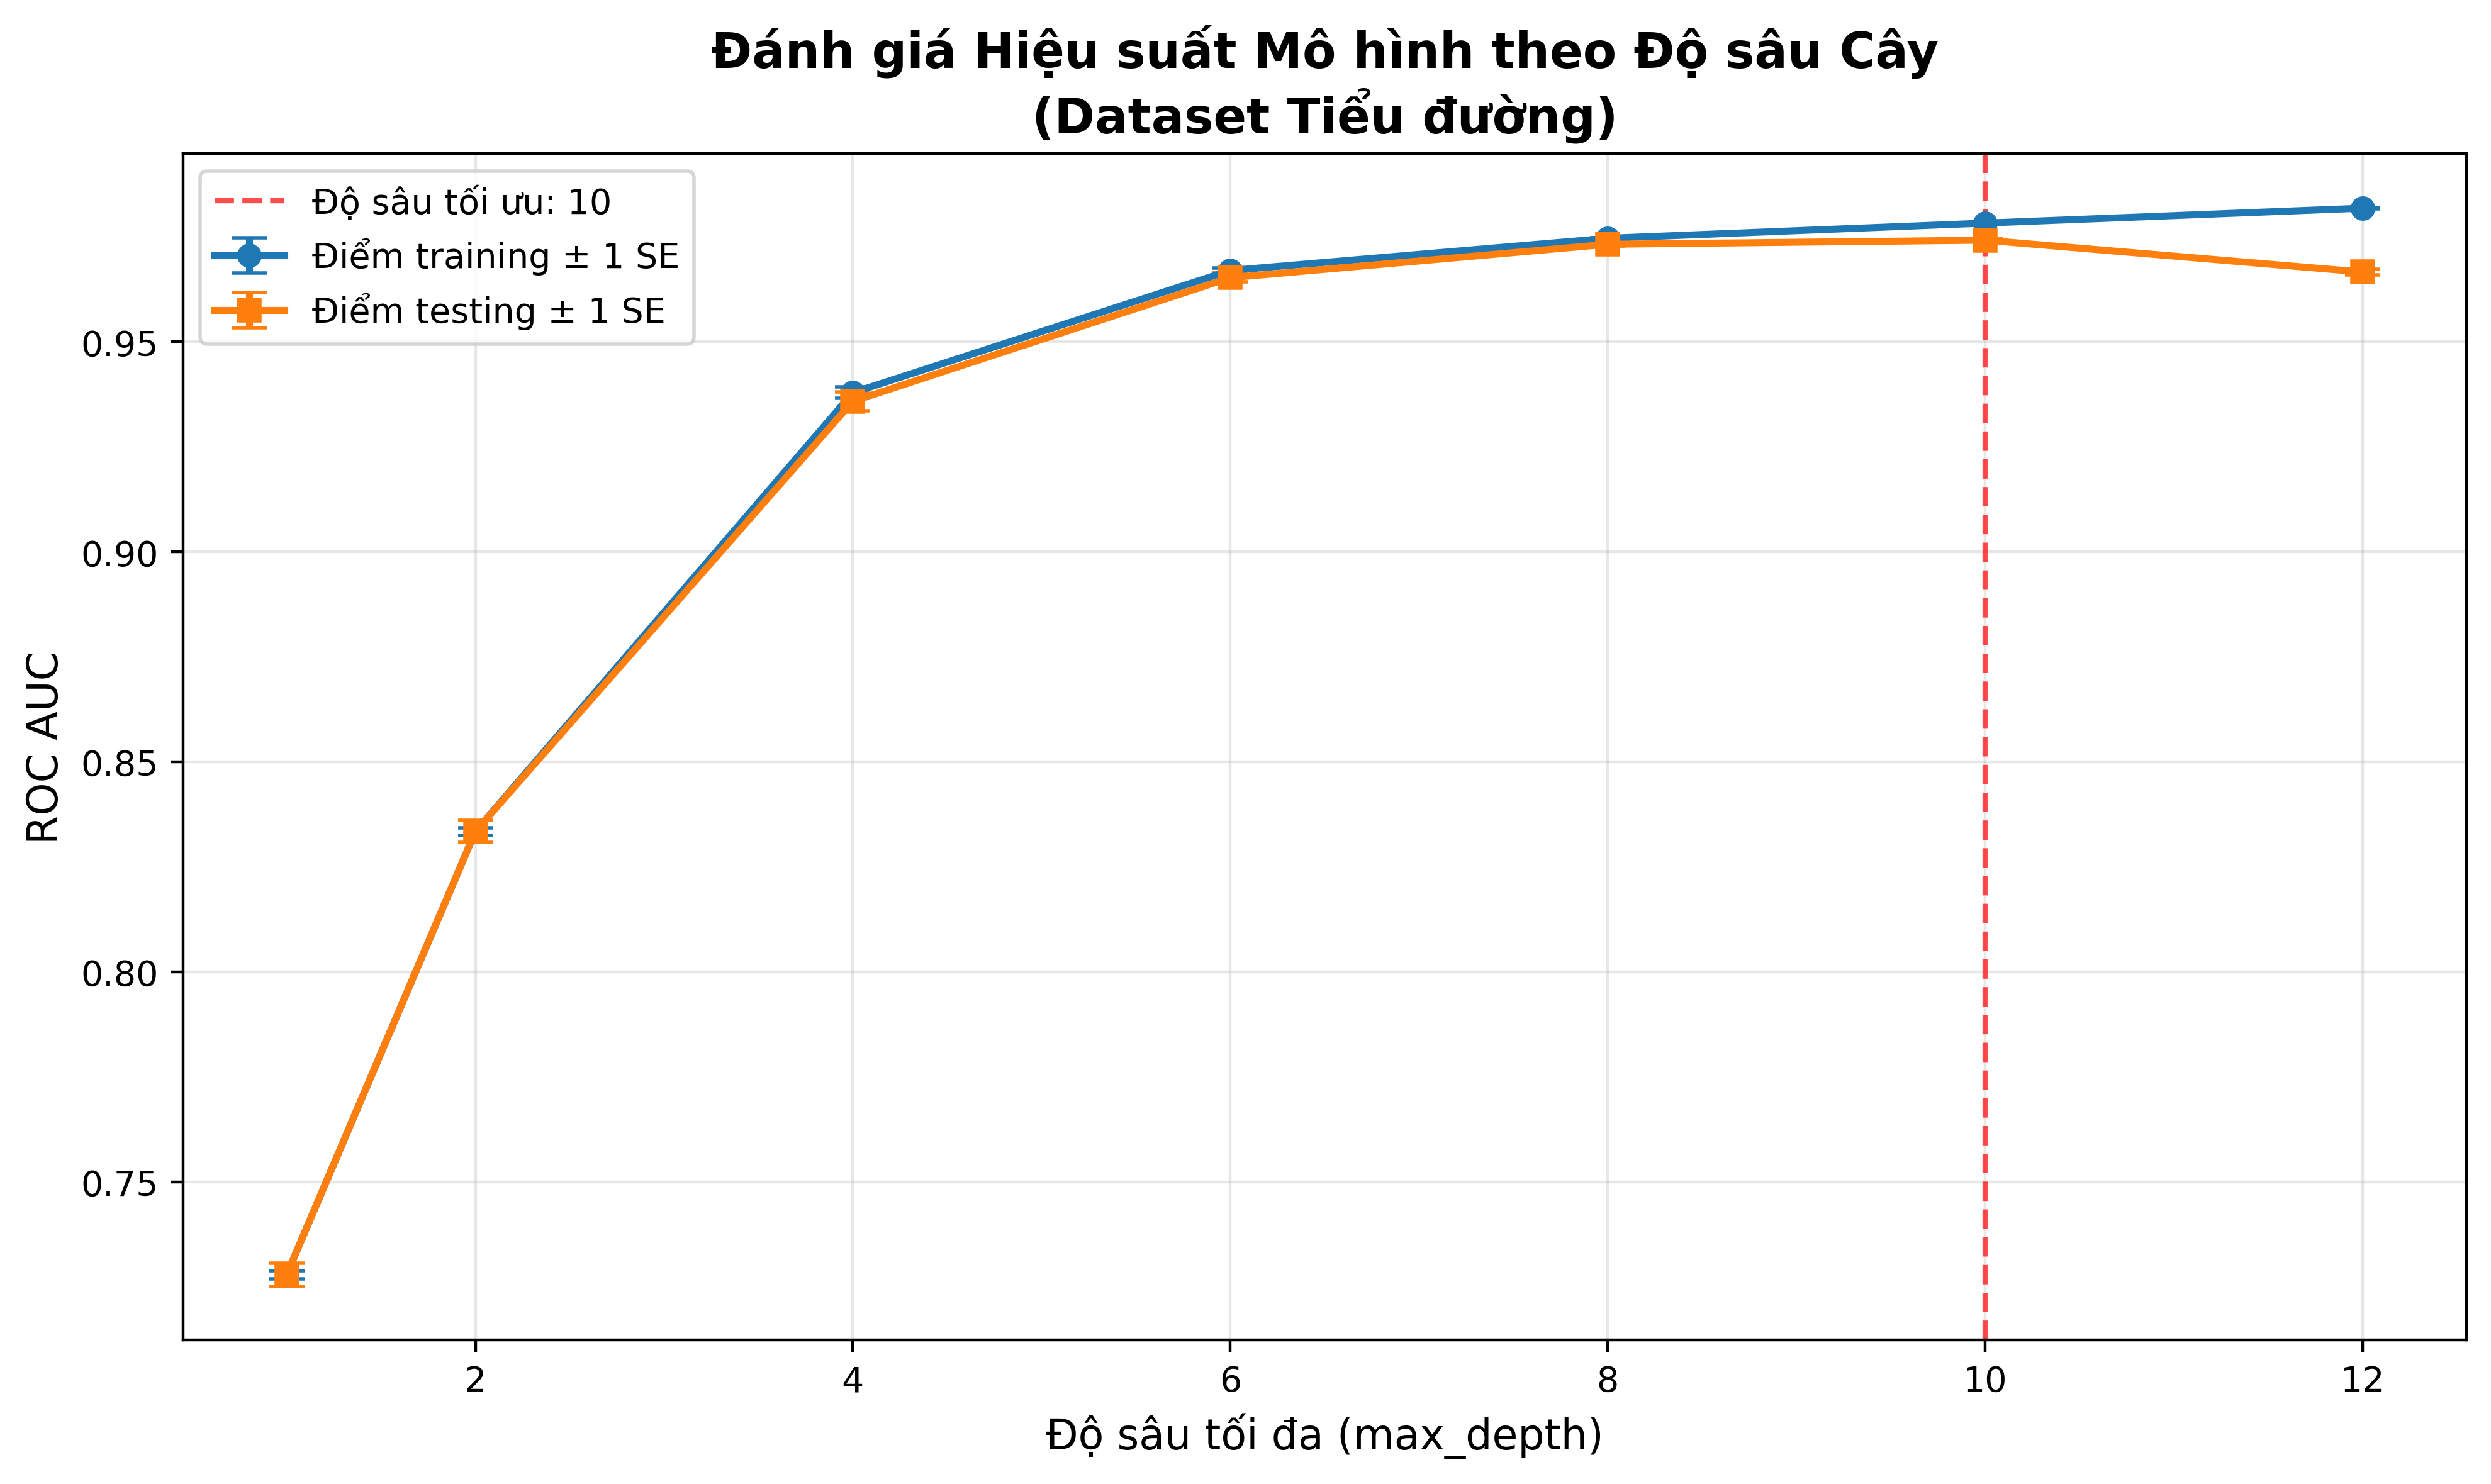

In [5]:
# Định nghĩa các tham số cần tối ưu
params = {'max_depth': [1, 2, 4, 6, 8, 10, 12]}  # Độ sâu của cây cần thử

# Tạo mô hình cây quyết định
dt = tree.DecisionTreeClassifier(random_state=24)  # Thêm random_state để kết quả ổn định

# Tạo GridSearchCV để tìm tham số tối ưu
cv = GridSearchCV(dt,
                  param_grid=params,
                  scoring='roc_auc',  # Sử dụng ROC AUC để đánh giá
                  n_jobs=None,
                  refit=True,         # Tự động huấn luyện lại với tham số tốt nhất
                  cv=4,               # 4-fold cross validation
                  verbose=1,          # Hiển thị tiến trình
                  error_score=np.nan,
                  return_train_score=True)  # Trả về điểm training để so sánh

# Chạy GridSearchCV trên dữ liệu tiểu đường
cv.fit(X_train, y_train)

# Chuyển kết quả thành DataFrame để phân tích
cv_results_df = pd.DataFrame(cv.cv_results_)

results_display = cv_results_df[['param_max_depth', 'mean_train_score', 'mean_test_score', 'std_test_score']]

# Vẽ biểu đồ so sánh hiệu suất
plt.figure(figsize=(10, 6))
ax = plt.axes()

# Vẽ đường training score với vùng sai số
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_train_score'],
            yerr=cv_results_df['std_train_score']/np.sqrt(4),  # Standard Error = std/sqrt(n_folds)
            label='Điểm training ± 1 SE',
            marker='o',
            linewidth=2,
            capsize=5)

# Vẽ đường testing score với vùng sai số
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_test_score'],
            yerr=cv_results_df['std_test_score']/np.sqrt(4),   # Standard Error = std/sqrt(n_folds)
            label='Điểm testing ± 1 SE',
            marker='s',
            linewidth=2,
            capsize=5)

# Tùy chỉnh biểu đồ
ax.legend(fontsize=12)
plt.xlabel('Độ sâu tối đa (max_depth)', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.title('Đánh giá Hiệu suất Mô hình theo Độ sâu Cây\n(Dataset Tiểu đường)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Highlight điểm tốt nhất
best_depth = cv.best_params_['max_depth']
best_score = cv.best_score_
plt.axvline(x=best_depth, color='red', linestyle='--', alpha=0.7, label=f'Độ sâu tối ưu: {best_depth}')

plt.legend()
plt.tight_layout()
plt.show()

# Huấn luyện lại mô hình với tham số tối ưu
best_dt = cv.best_estimator_

**Nhận xét:** Kết quả tìm kiếm tham số tối ưu bằng GridSearchCV cho thấy độ sâu tối ưu của cây quyết định là 10, đạt điểm ROC AUC khoảng 0.95 trên tập validation. Điều đáng chú ý là hiệu suất mô hình tiếp tục được cải thiện khi tăng độ sâu từ 1 lên 10, chứng tỏ dữ liệu tiểu đường có cấu trúc khá phức tạp đòi hỏi mô hình đủ sâu để nắm bắt các mẫu quan trọng. Tuy nhiên, khoảng cách giữa điểm training và testing ở độ sâu 10 cho thấy có dấu hiệu overfitting, khi mô hình học quá khớp với dữ liệu huấn luyện. Sự ổn định của đường testing score từ độ sâu 6 đến 12 cho thấy mô hình đã đạt đến ngưỡng hiệu suất gần tối đa có thể đạt được với kiến trúc cây quyết định này. Kết quả ROC AUC đạt 0.95 là rất ấn tượng, thể hiện khả năng phân loại xuất sắc giữa bệnh nhân tiểu đường và không tiểu đường, phù hợp cho ứng dụng thực tế trong sàng lọc và chẩn đoán.

**Xây dựng Rừng Cây**

Fitting 4 folds for each of 10 candidates, totalling 40 fits


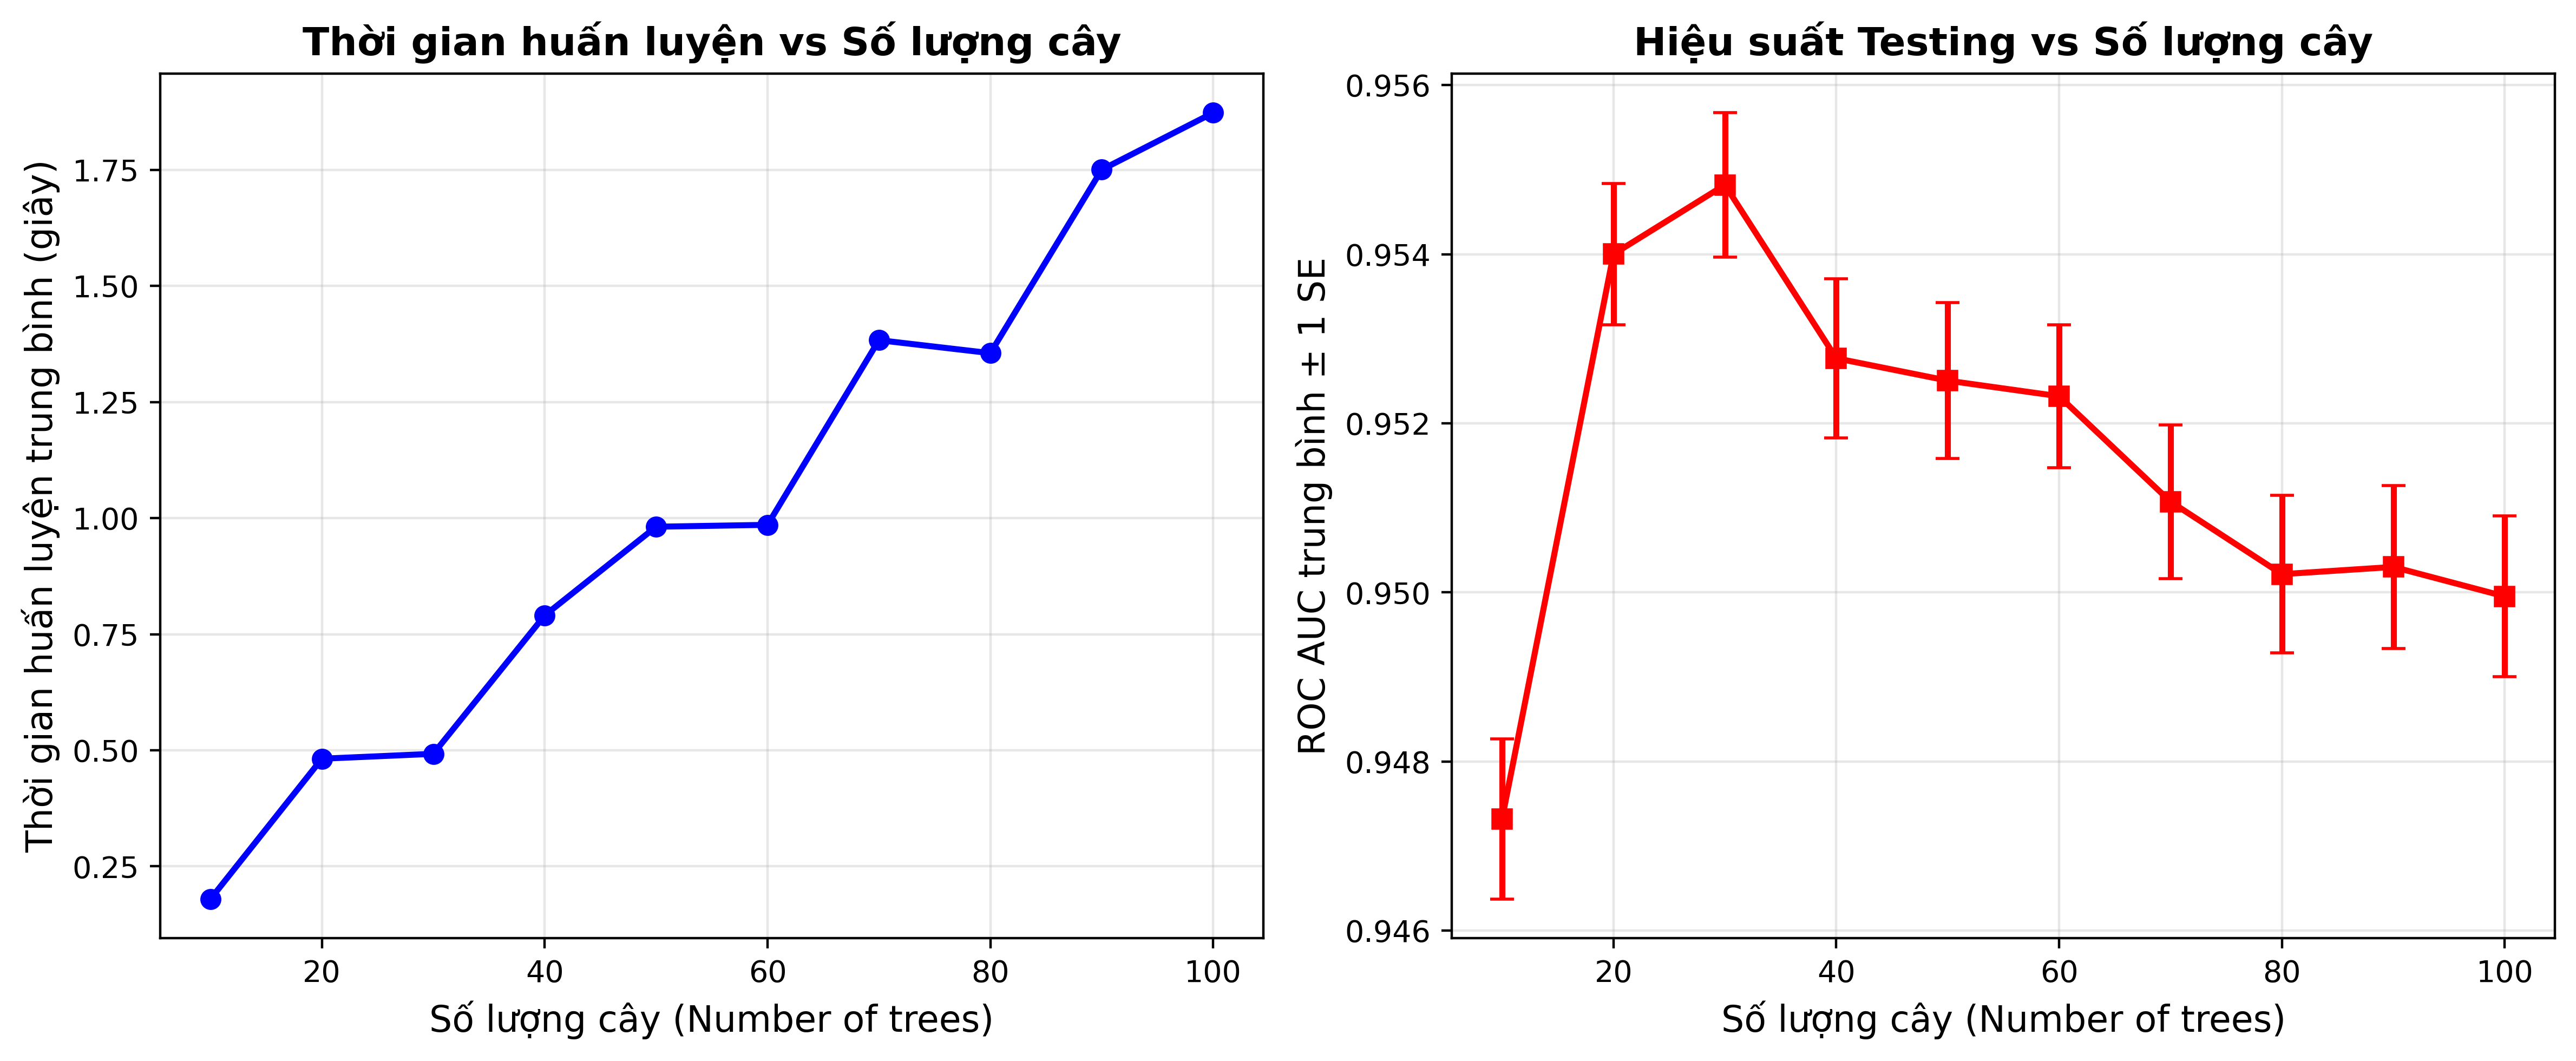

<Figure size 4000x2400 with 0 Axes>

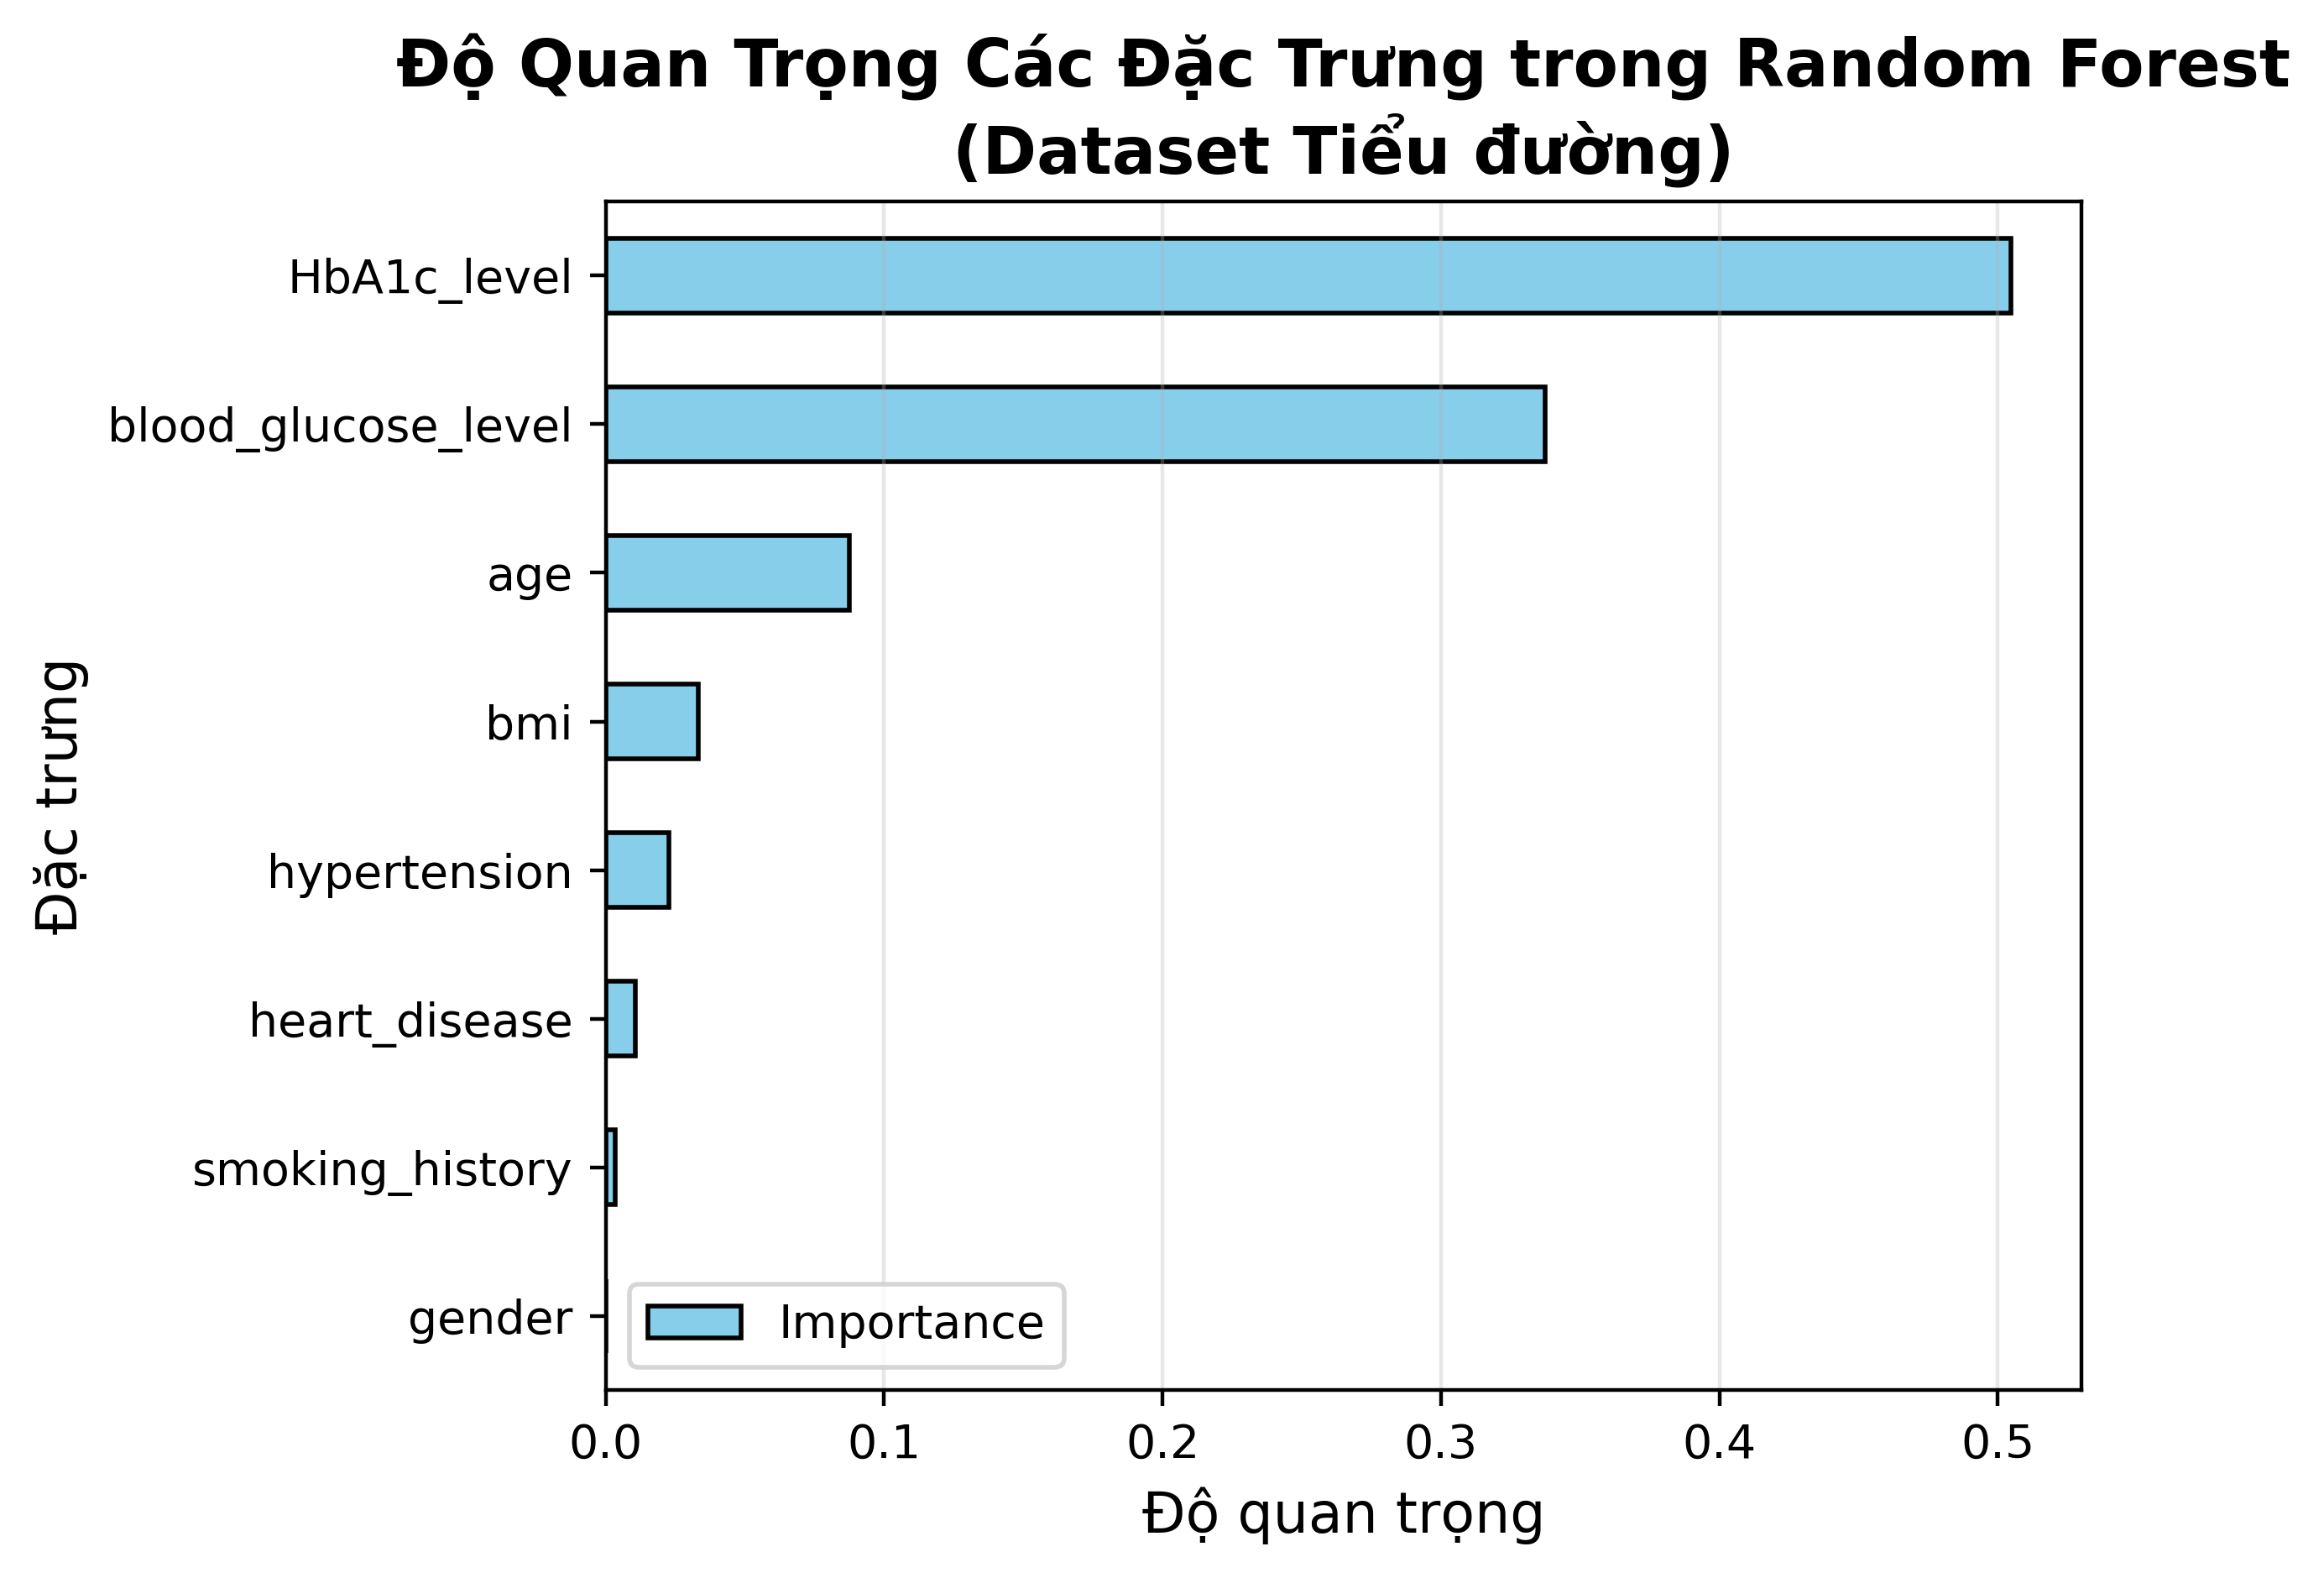

In [6]:
# Tạo mô hình Random Forest
rf = RandomForestClassifier(
    n_estimators=10,
    criterion='gini',
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=4,
    verbose=0,
    warm_start=False,
    class_weight=None
)

# Tạo lưới tham số để tìm số cây tối ưu (từ 10 đến 100, bước nhảy 10)
rf_params_ex = {'n_estimators': list(range(10, 110, 10))}

# Tạo GridSearchCV cho Random Forest
cv_rf_ex = GridSearchCV(rf,
                       param_grid=rf_params_ex,
                       scoring='roc_auc',
                       n_jobs=None,
                       refit=True,
                       cv=4,
                       verbose=1,
                       error_score=np.nan,
                       return_train_score=True)

# Huấn luyện mô hình trên dữ liệu tiểu đường
cv_rf_ex.fit(X_train, y_train)

# Chuyển kết quả thành DataFrame
cv_rf_ex_results_df = pd.DataFrame(cv_rf_ex.cv_results_)

# Vẽ biểu đồ so sánh thời gian huấn luyện và hiệu suất
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Biểu đồ 1: Thời gian huấn luyện
axs[0].plot(cv_rf_ex_results_df['param_n_estimators'],
           cv_rf_ex_results_df['mean_fit_time'],
           '-o', color='blue', linewidth=2, markersize=6)
axs[0].set_xlabel('Số lượng cây (Number of trees)', fontsize=12)
axs[0].set_ylabel('Thời gian huấn luyện trung bình (giây)', fontsize=12)
axs[0].set_title('Thời gian huấn luyện vs Số lượng cây', fontsize=13, fontweight='bold')
axs[0].grid(True, alpha=0.3)

# Biểu đồ 2: Hiệu suất ROC AUC
axs[1].errorbar(cv_rf_ex_results_df['param_n_estimators'],
               cv_rf_ex_results_df['mean_test_score'],
               yerr=cv_rf_ex_results_df['std_test_score']/np.sqrt(4),
               color='red', linewidth=2, marker='s', markersize=6, capsize=4)
axs[1].set_xlabel('Số lượng cây (Number of trees)', fontsize=12)
axs[1].set_ylabel('ROC AUC trung bình ± 1 SE', fontsize=12)
axs[1].set_title('Hiệu suất Testing vs Số lượng cây', fontsize=13, fontweight='bold')
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Hiển thị tham số tốt nhất

# Phân tích độ quan trọng của các feature
feat_imp_df = pd.DataFrame({
    'Importance': cv_rf_ex.best_estimator_.feature_importances_
}, index=features_response[:-1])

# Sắp xếp và vẽ biểu đồ độ quan trọng feature
plt.figure(figsize=(10, 6))
feat_imp_df.sort_values('Importance', ascending=True).plot.barh(
    color='skyblue', edgecolor='black'
)
plt.title('Độ Quan Trọng Các Đặc Trưng trong Random Forest\n(Dataset Tiểu đường)',
          fontsize=14, fontweight='bold')
plt.xlabel('Độ quan trọng', fontsize=12)
plt.ylabel('Đặc trưng', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Hiển thị bảng độ quan trọng chi tiết
feat_imp_sorted = feat_imp_df.sort_values('Importance', ascending=False)

# Đánh giá mô hình tốt nhất trên tập test
best_rf = cv_rf_ex.best_estimator_
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]
test_roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

**NHẬN XÉT BIỂU ĐỒ THỜI GIAN HUẤN LUYỆN:** Biểu đồ thời gian huấn luyện cho thấy mối quan hệ tuyến tính giữa số lượng cây và thời gian huấn luyện - càng nhiều cây thì thời gian huấn luyện càng tăng. Đây là kết quả hoàn toàn dự đoán được do mỗi cây bổ sung đều yêu cầu thêm tài nguyên tính toán. Tuy nhiên, tốc độ tăng thời gian là chấp nhận được, cho phép sử dụng số lượng cây lớn mà không làm ảnh hưởng quá nhiều đến hiệu suất tính toán tổng thể của mô hình.

**NHẬN XÉT BIỂU ĐỒ HIỆU SUẤT ROC AUC:** Biểu đồ hiệu suất ROC AUC cho thấy mô hình Random Forest đạt kết quả rất ấn tượng với ROC AUC khoảng 0.955, thể hiện khả năng phân loại xuất sắc. Điều đáng chú ý là hiệu suất mô hình khá ổn định across different numbers of trees, với biến động rất nhỏ khi số cây thay đổi từ 10 đến 100. Điều này cho thấy mô hình đã đạt đến ngưỡng hiệu suất gần tối đa ngay cả với số cây khiêm tốn, và việc tăng thêm số cây không mang lại cải thiện đáng kể về độ chính xác nhưng lại làm tăng thời gian huấn luyện.

**NHẬN XÉT BIỂU ĐỒ ĐỘ QUAN TRỌNG ĐẶC TRƯNG:** Biểu đồ độ quan trọng các đặc trưng cho thấy HbA1c_level và blood_glucose_level là hai yếu tố quan trọng nhất trong việc dự đoán bệnh tiểu đường, chiếm tỷ trọng lớn trong mô hình. Điều này hoàn toàn phù hợp với kiến thức y khoa khi đây là hai chỉ số trực tiếp phản ánh tình trạng đường huyết của bệnh nhân. Tuổi (age) cũng thể hiện vai trò đáng kể, phản ánh thực tế nguy cơ tiểu đường tăng theo độ tuổi. Các yếu tố như BMI, hypertension có mức độ quan trọng trung bình, trong khi heart_disease, smoking_history và gender có đóng góp ít hơn trong mô hình dự đoán này.

##2.2.3. Xây dựng mô hình từ giải thuật SVM trên dữ liệu bệnh tiểu đường.

🎯 BÀI TOÁN SVM DỰ ĐOÁN BỆNH TIỂU ĐƯỜNG
✅ Training: (80000, 8), Testing: (20000, 8)

2. SO SÁNH CÁC KERNEL SVM...
   linear   | Train: 0.9610 | Test: 0.9607
   poly     | Train: 0.9644 | Test: 0.9647
   rbf      | Train: 0.9642 | Test: 0.9639
   sigmoid  | Train: 0.9167 | Test: 0.9160
⭐ KERNEL TỐT NHẤT: poly

3. PHÂN TÍCH DỮ LIỆU...


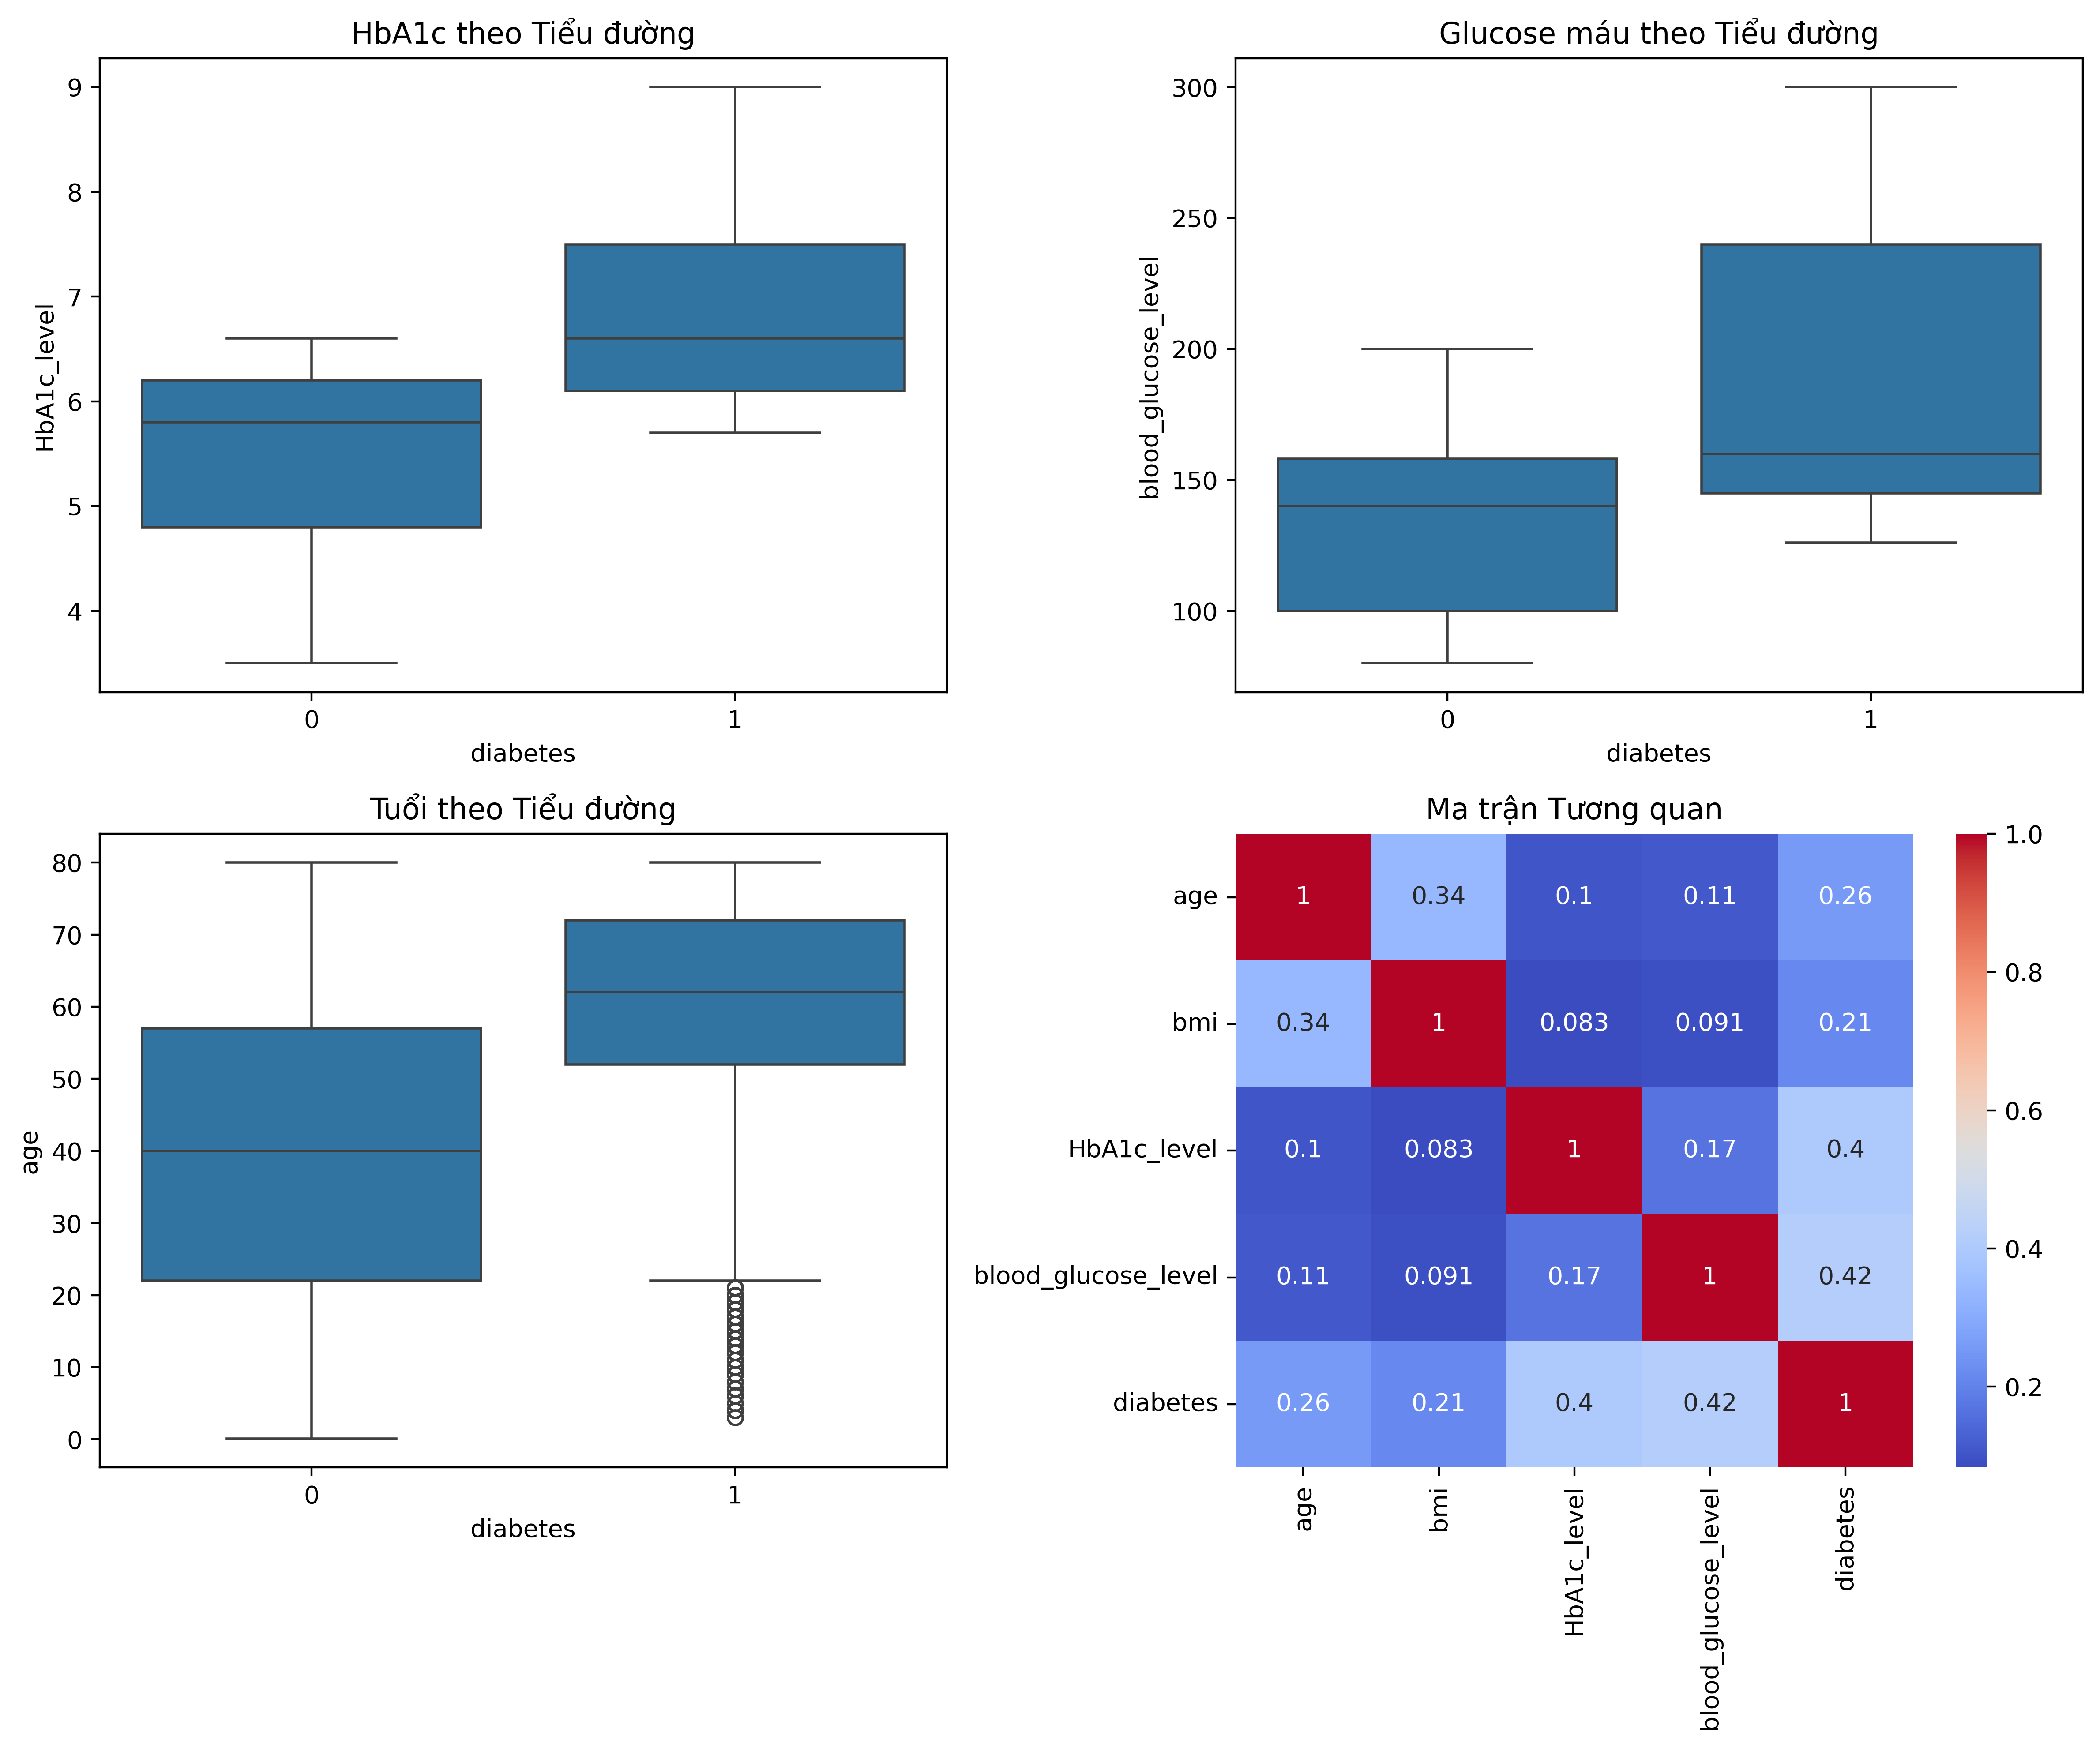


4. ĐÁNH GIÁ MÔ HÌNH TỐT NHẤT...


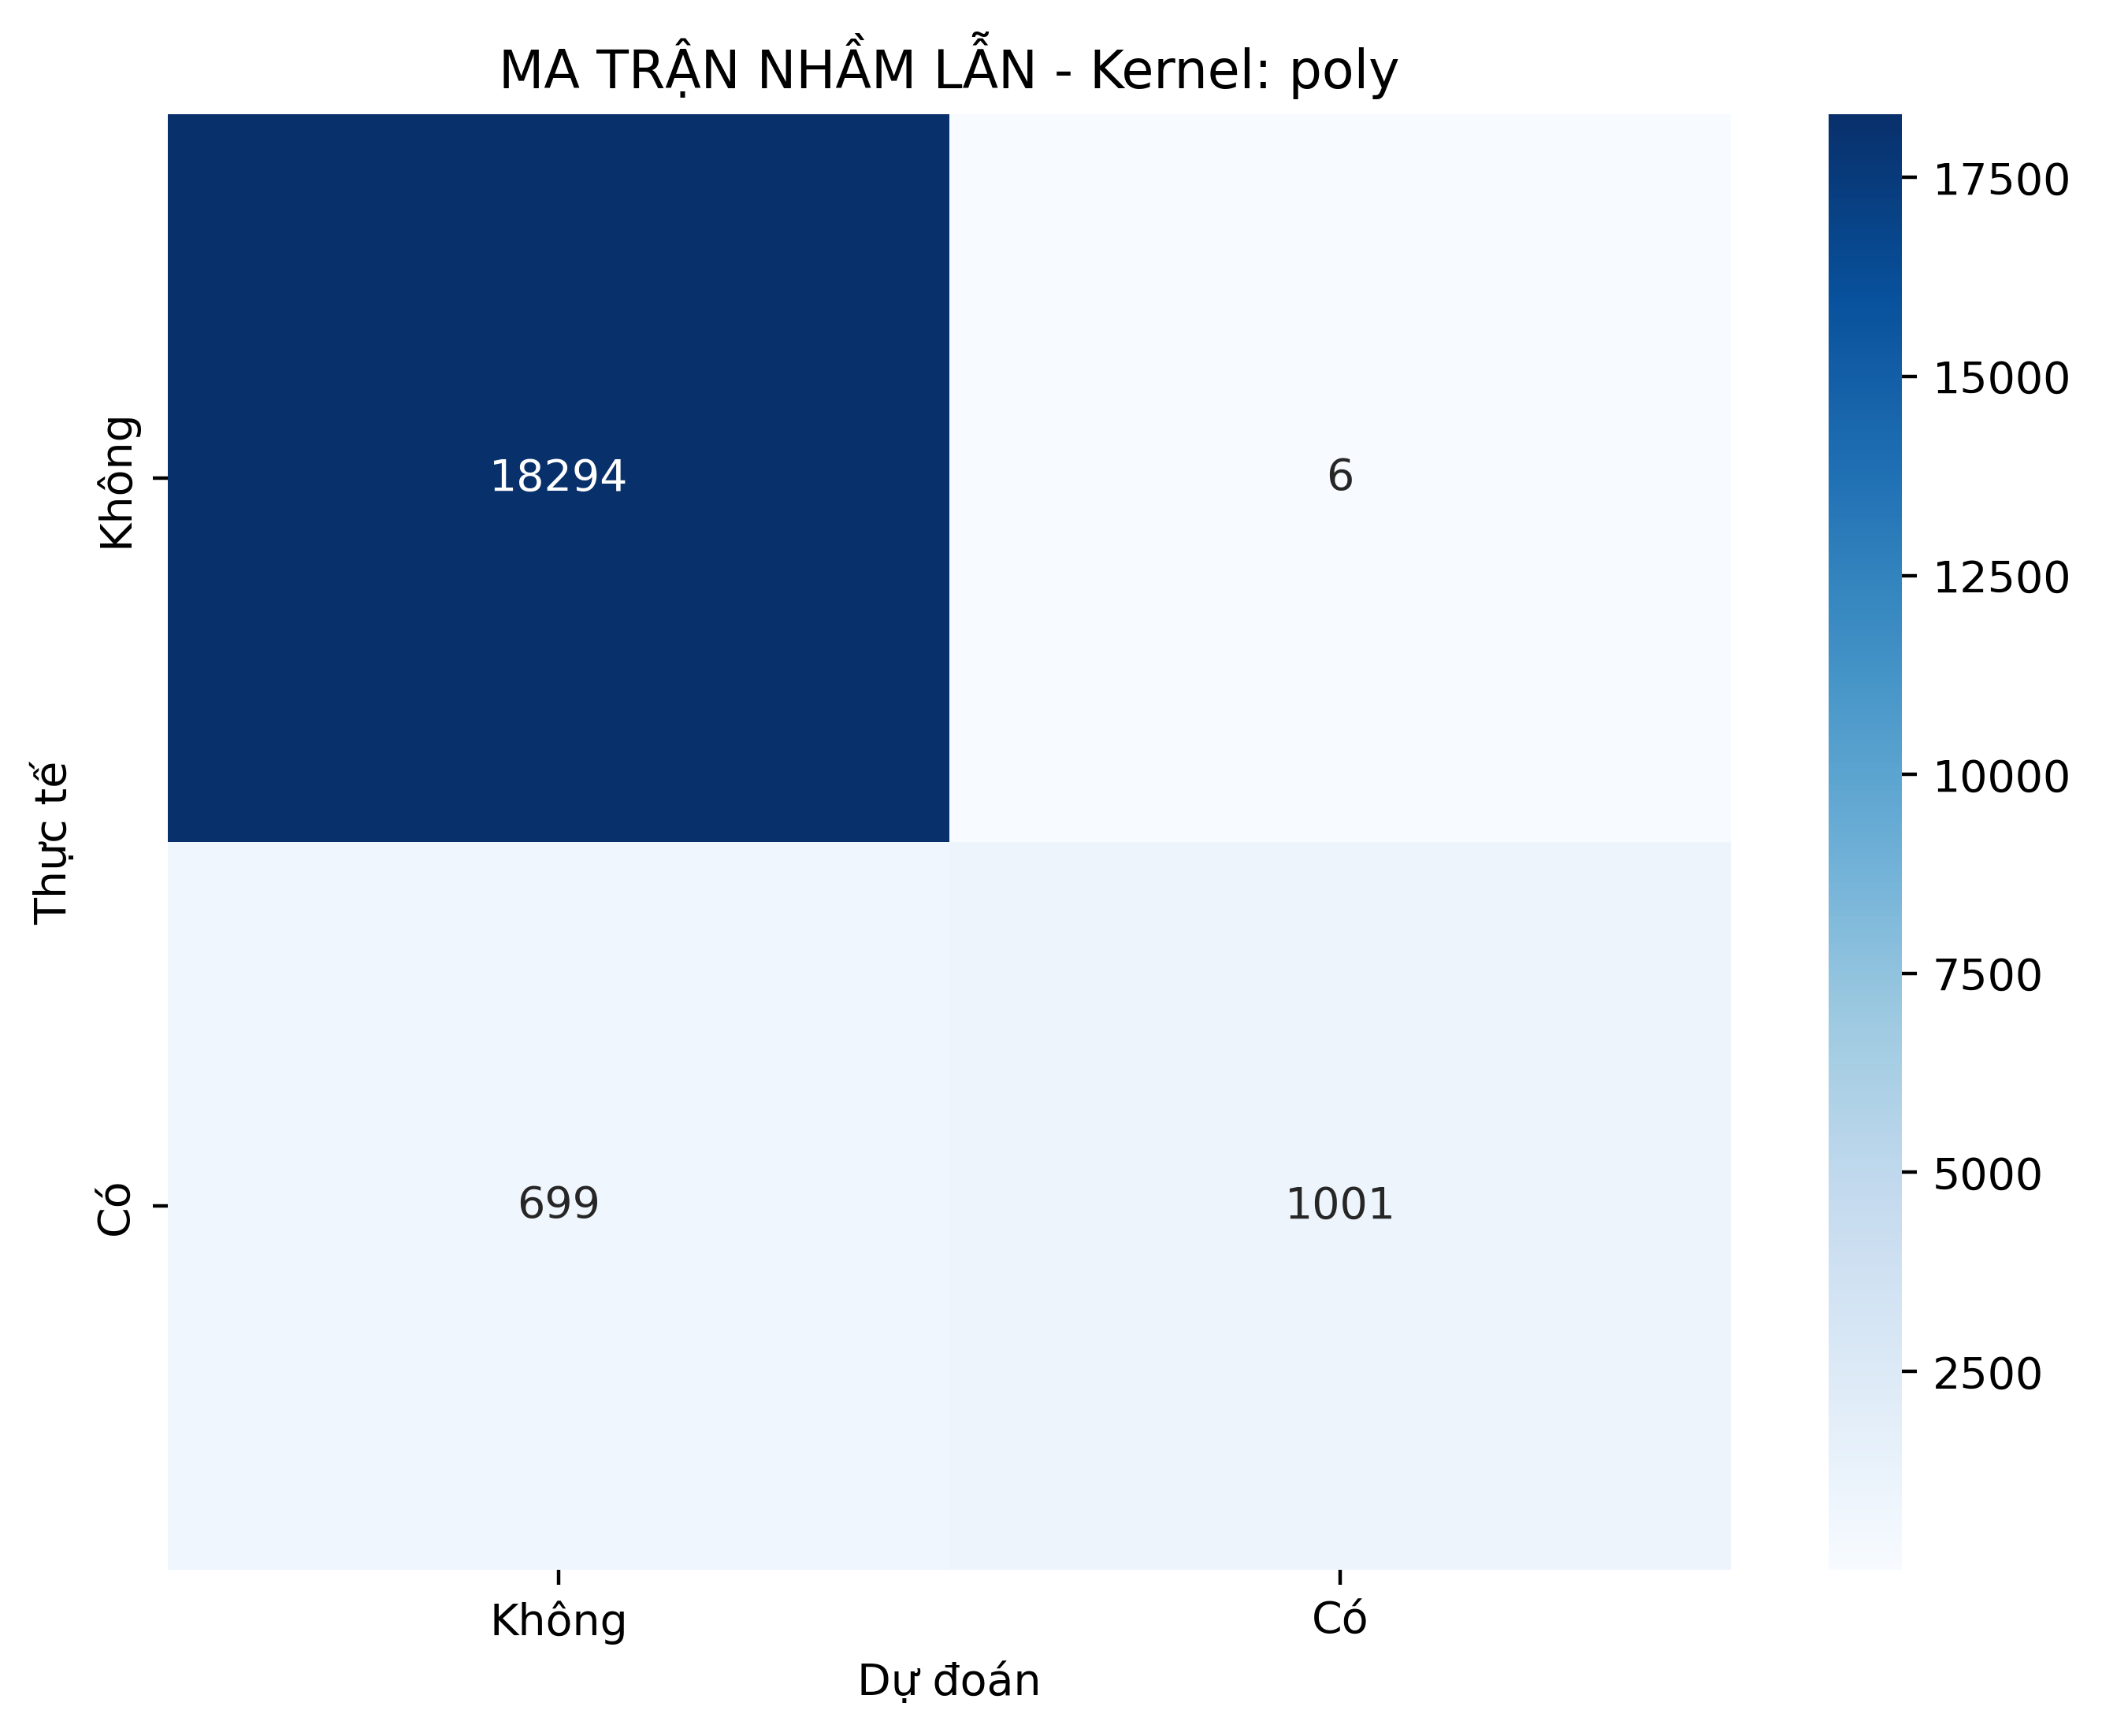


📊 BÁO CÁO PHÂN LOẠI:
                  precision    recall  f1-score   support

Không tiểu đường       0.96      1.00      0.98     18300
      Tiểu đường       0.99      0.59      0.74      1700

        accuracy                           0.96     20000
       macro avg       0.98      0.79      0.86     20000
    weighted avg       0.97      0.96      0.96     20000

🎯 KẾT QUẢ CUỐI CÙNG
Kernel tốt nhất: poly
Độ chính xác cuối cùng: 0.9647
Số features: 8
Kích thước tập test: 20000 mẫu


In [4]:
print("🎯 BÀI TOÁN SVM DỰ ĐOÁN BỆNH TIỂU ĐƯỜNG")
print("=" * 50)


df_processed = fec.copy()

# Mã hóa categorical
label_encoders = {}
for col in ['gender', 'smoking_history']:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    label_encoders[col] = le

features = ['gender', 'age', 'hypertension', 'heart_disease',
           'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']
target = 'diabetes'

X = df_processed[features]
y = df_processed[target]

# Chuẩn hóa
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Chia data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=101, stratify=y
)

print(f"✅ Training: {X_train.shape}, Testing: {X_test.shape}")

# 2. SO SÁNH CÁC KERNEL (Bài toán 1)
print("\n2. SO SÁNH CÁC KERNEL SVM...")

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
results = {}

for kernel in kernels:
    model = svm.SVC(kernel=kernel, random_state=101)
    model.fit(X_train, y_train)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    results[kernel] = {'model': model, 'train_acc': train_acc, 'test_acc': test_acc}

    print(f"   {kernel:8} | Train: {train_acc:.4f} | Test: {test_acc:.4f}")

# Tìm kernel tốt nhất
best_kernel = max(results, key=lambda x: results[x]['test_acc'])
best_model = results[best_kernel]['model']
print(f"⭐ KERNEL TỐT NHẤT: {best_kernel}")

# 3. PHÂN TÍCH DỮ LIỆU (Bài toán 2)
print("\n3. PHÂN TÍCH DỮ LIỆU...")

# Vẽ distribution plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# HbA1c distribution by diabetes
sns.boxplot(x='diabetes', y='HbA1c_level', data=fec, ax=axes[0,0])
axes[0,0].set_title('HbA1c theo Tiểu đường')

# Glucose distribution by diabetes
sns.boxplot(x='diabetes', y='blood_glucose_level', data=fec, ax=axes[0,1])
axes[0,1].set_title('Glucose máu theo Tiểu đường')

# Age distribution by diabetes
sns.boxplot(x='diabetes', y='age', data=fec, ax=axes[1,0])
axes[1,0].set_title('Tuổi theo Tiểu đường')

# Correlation heatmap
numeric_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
corr_matrix = fec[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=axes[1,1])
axes[1,1].set_title('Ma trận Tương quan')

plt.tight_layout()
plt.show()

# 4. ĐÁNH GIÁ MÔ HÌNH TỐT NHẤT
print("\n4. ĐÁNH GIÁ MÔ HÌNH TỐT NHẤT...")

# Dự đoán với model tốt nhất
y_pred = best_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Không', 'Có'],
            yticklabels=['Không', 'Có'])
plt.title(f'MA TRẬN NHẦM LẪN - Kernel: {best_kernel}')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

# Classification Report
print("\n📊 BÁO CÁO PHÂN LOẠI:")
print(classification_report(y_test, y_pred,
                          target_names=['Không tiểu đường', 'Tiểu đường']))

# 5. KẾT LUẬN
final_accuracy = accuracy_score(y_test, y_pred)
print("=" * 50)
print("🎯 KẾT QUẢ CUỐI CÙNG")
print("=" * 50)
print(f"Kernel tốt nhất: {best_kernel}")
print(f"Độ chính xác cuối cùng: {final_accuracy:.4f}")
print(f"Số features: {len(features)}")
print(f"Kích thước tập test: {len(X_test)} mẫu")

**NHẬN XÉT TỔNG QUAN:** Mô hình SVM đã đạt được kết quả ấn tượng với độ chính xác tổng thể 96.47% trong việc dự đoán bệnh tiểu đường, sử dụng kernel polynomial cho hiệu suất tốt nhất. Điều này cho thấy mối quan hệ giữa các đặc trưng lâm sàng và bệnh tiểu đường có tính chất phi tuyến phức tạp, phù hợp với kernel poly hơn so với các kernel khác. Kết quả này khẳng định tính khả thi của việc ứng dụng machine learning trong hỗ trợ chẩn đoán y tế, đặc biệt với các bệnh mãn tính như tiểu đường.

**SO SÁNH HIỆU SUẤT GIỮA CÁC KERNEL:** Trong số bốn kernel được đánh giá, kernel polynomial thể hiện ưu thế nhẹ với độ chính xác 96.47% trên tập test, theo sát là kernel RBF (96.39%) và linear (96.07%). Sự chênh lệch không đáng kể giữa các kernel này cho thấy bài toán có thể tiếp cận được bằng cả phương pháp tuyến tính và phi tuyến. Kernel sigmoid cho kết quả thấp nhất (91.60%), phù hợp với lý thuyết khi sigmoid thường kém hiệu quả với các bài toán phân loại phức tạp. Đáng chú ý là hiệu suất trên tập train và test tương đối đồng đều across các kernel, chứng tỏ mô hình không bị overfitting.

**PHÂN TÍCH VẤN ĐỀ MẤT CÂN BẰNG LỚP:** Mặc dù đạt độ chính xác tổng thể cao, kết quả cho thấy một vấn đề quan trọng về mất cân bằng lớp. Trong khi lớp "Không tiểu đường" đạt recall gần như hoàn hảo (100%) với f1-score 0.98, lớp "Tiểu đường" chỉ đạt recall 59% với f1-score 0.74. Điều này có nghĩa mô hình bỏ sót tới 41% trường hợp tiểu đường thực tế - một tỷ lệ đáng báo động trong bối cảnh y tế. Precision cao (99%) cho lớp tiểu đường cho thấy khi mô hình dự đoán có bệnh thì rất chính xác, nhưng khả năng phát hiện bệnh nhân thực sự còn hạn chế.

**ĐÁNH GIÁ ỨNG DỤNG THỰC TIỄN:** Với độ chính xác 96.47%, mô hình có tiềm năng ứng dụng trong sàng lọc ban đầu tại các cơ sở y tế, giúp giảm tải cho hệ thống chẩn đoán truyền thống. Tuy nhiên, recall thấp ở lớp thiểu số (tiểu đường) là điểm yếu nghiêm trọng trong bối cảnh y tế, nơi việc bỏ sót bệnh nhân có thể dẫn đến hậu quả nặng nề. Mô hình hiện tại phù hợp hơn cho việc xác nhận các trường hợp không mắc bệnh thay vì phát hiện bệnh mới.

**KHUYẾN NGHỊ CẢI THIỆN MÔ HÌNH:** Để nâng cao hiệu suất thực tế, cần tập trung vào việc cải thiện recall cho lớp tiểu đường thông qua các kỹ thuật xử lý mất cân bằng lớp như SMOTE, điều chỉnh class weights, hoặc sử dụng các giải thuật ít nhạy cảm với imbalance data. Việc điều chỉnh ngưỡng phân loại (threshold tuning) cũng có thể giúp cân bằng giữa precision và recall. Ngoài ra, có thể thử nghiệm với các ensemble methods kết hợp nhiều mô hình để cải thiện khả năng phát hiện các trường hợp khó.

**KẾT LUẬN:** Mô hình SVM với kernel poly đã chứng minh hiệu quả cao trong bài toán dự đoán tiểu đường, tuy nhiên cần giải quyết triệt để vấn đề mất cân bằng lớp để có thể ứng dụng thực tế trong chẩn đoán y tế. Kết quả này mở ra hướng phát triển các hệ thống hỗ trợ quyết định lâm sàng dựa trên dữ liệu bệnh nhân, góp phần nâng cao chất lượng chăm sóc sức khỏe cộng đồng.

##2.3.4. Xây dựng mô hình Naïve ngây thơ trên tập dữ liệu mushroom.

🍄 PHÂN LOẠI NẤM SỬ DỤNG NAÏVE BAYES
📊 Thông tin dataset:
Kích thước: (8124, 23)
Các cột: ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']

5 dòng đầu tiên:
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color  ... stalk-surface-below-ring  \
0            c       

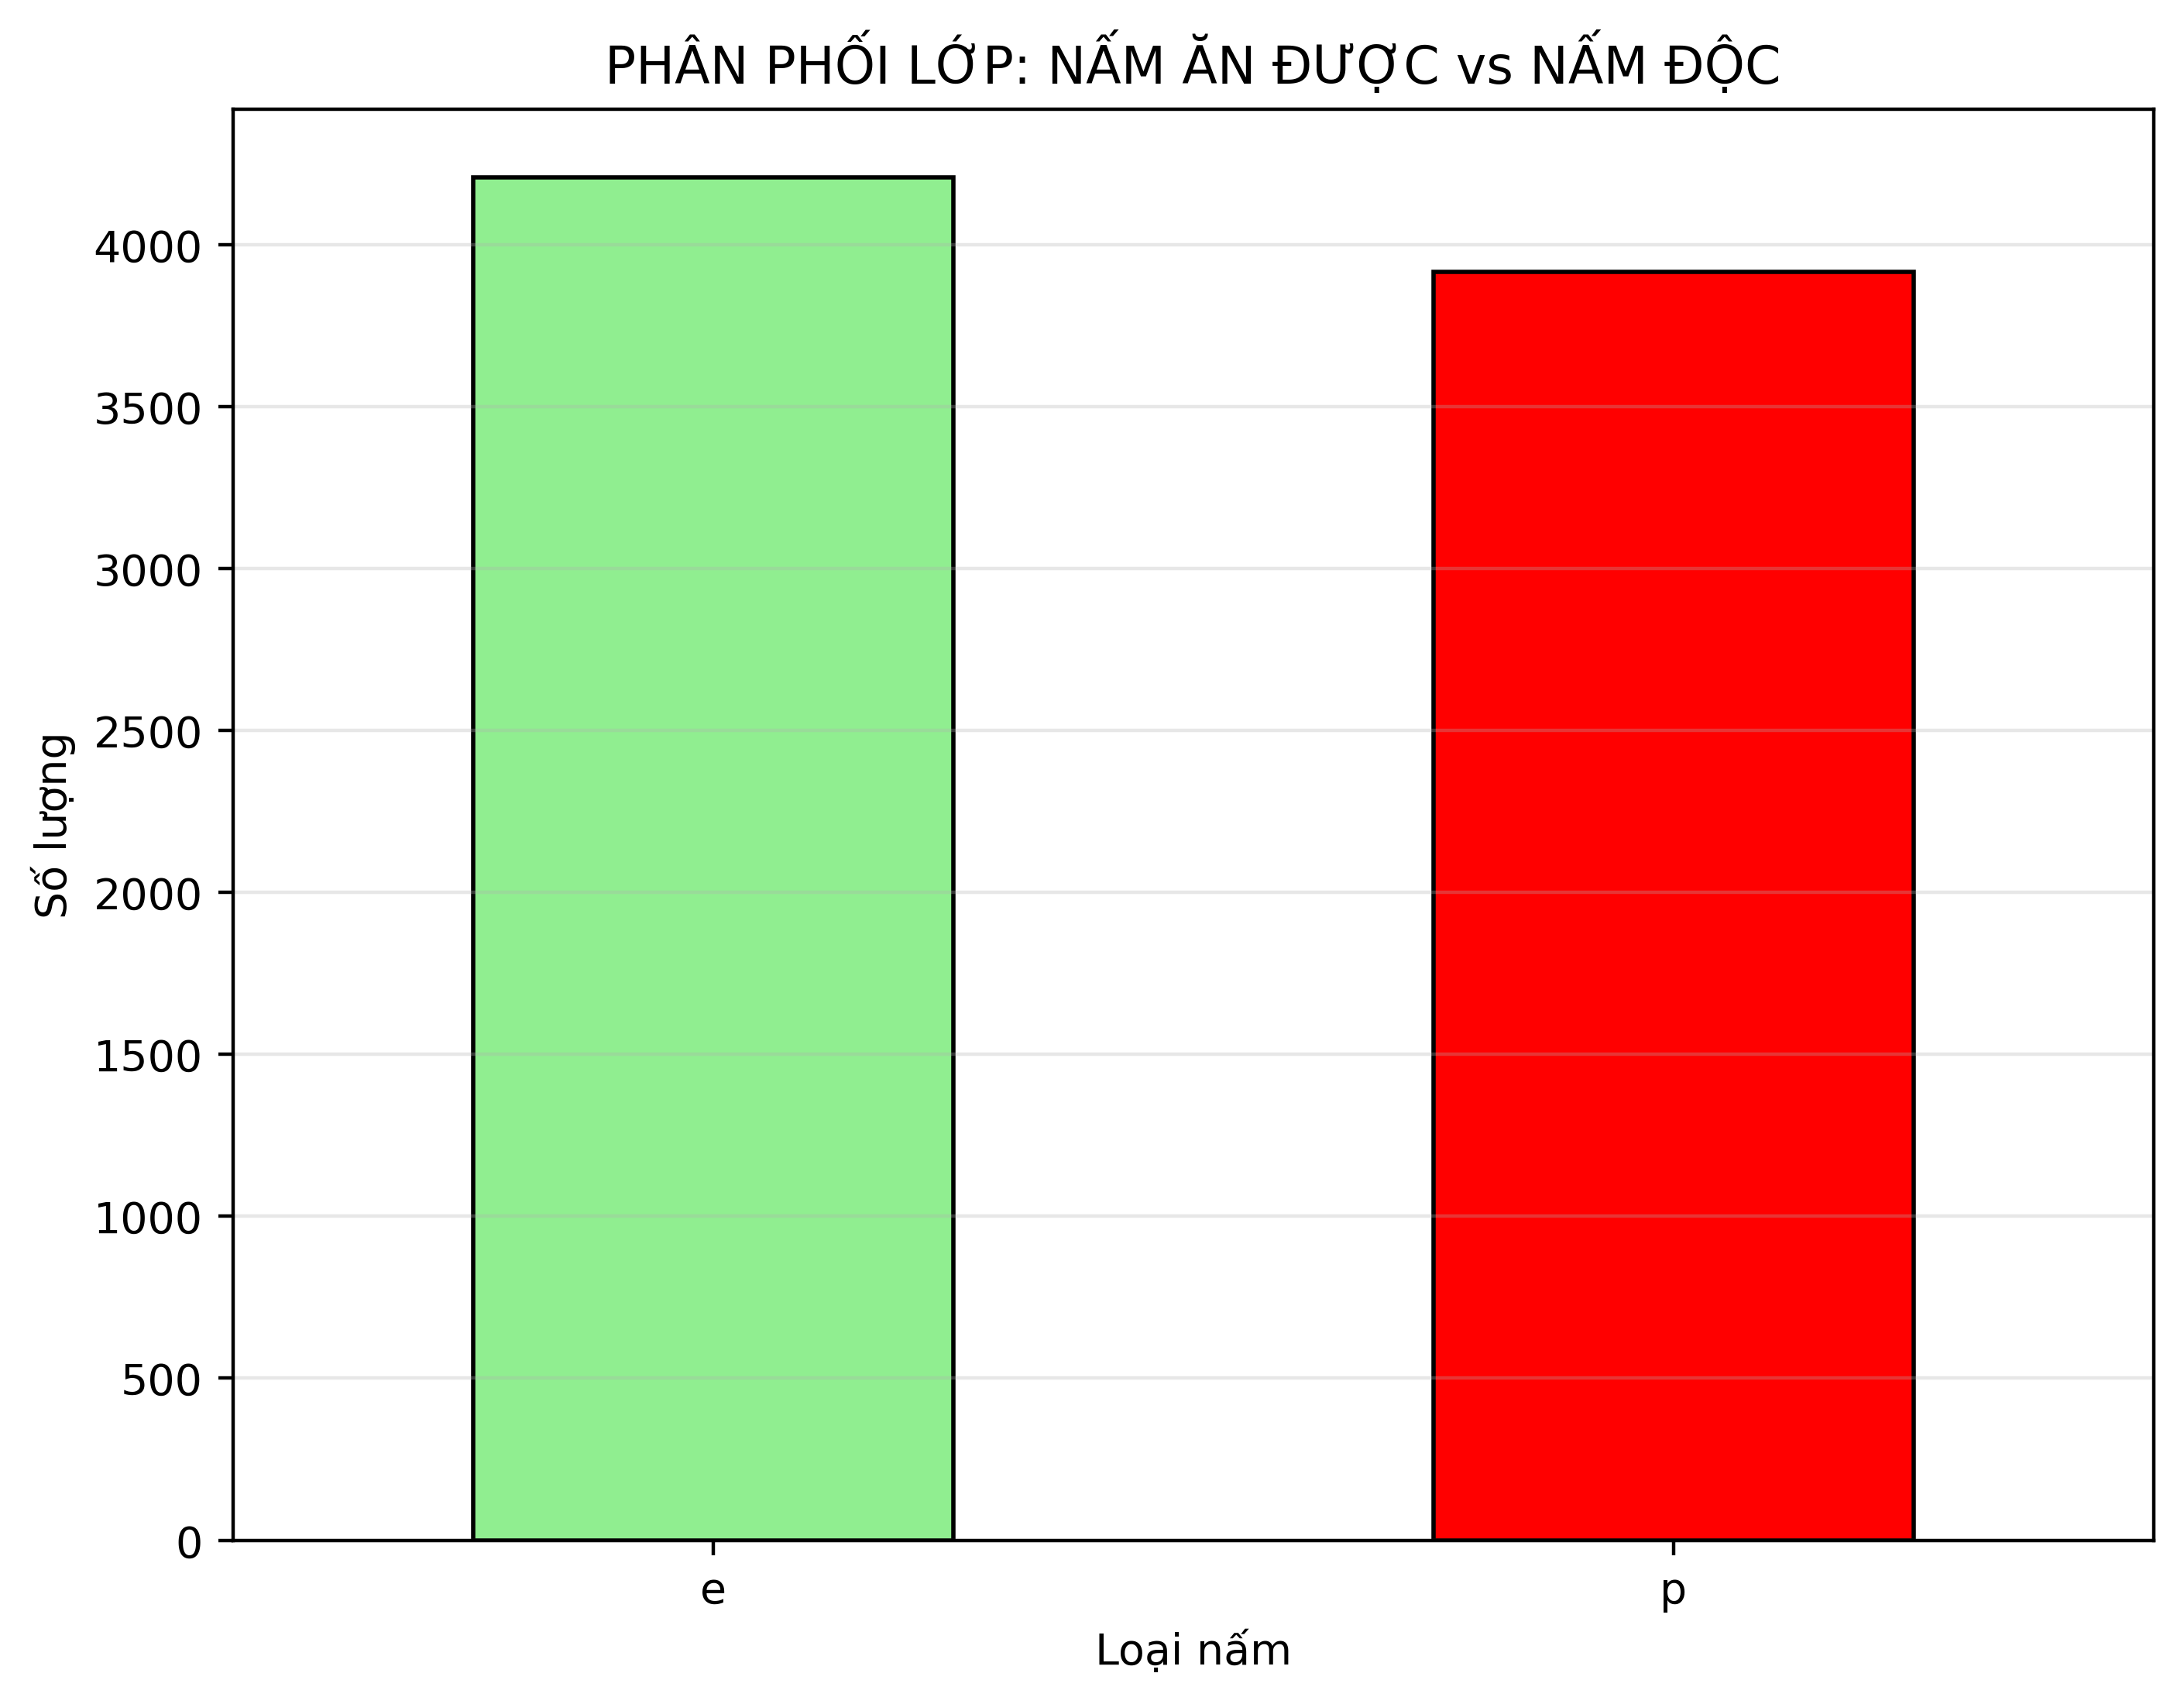


3. XỬ LÝ DỮ LIỆU PHÂN LOẠI
✅ Đã mã hóa class: 2 giá trị
✅ Đã mã hóa cap-shape: 6 giá trị
✅ Đã mã hóa cap-surface: 4 giá trị
✅ Đã mã hóa cap-color: 10 giá trị
✅ Đã mã hóa bruises: 2 giá trị
✅ Đã mã hóa odor: 9 giá trị
✅ Đã mã hóa gill-attachment: 2 giá trị
✅ Đã mã hóa gill-spacing: 2 giá trị
✅ Đã mã hóa gill-size: 2 giá trị
✅ Đã mã hóa gill-color: 12 giá trị
✅ Đã mã hóa stalk-shape: 2 giá trị
✅ Đã mã hóa stalk-root: 5 giá trị
✅ Đã mã hóa stalk-surface-above-ring: 4 giá trị
✅ Đã mã hóa stalk-surface-below-ring: 4 giá trị
✅ Đã mã hóa stalk-color-above-ring: 9 giá trị
✅ Đã mã hóa stalk-color-below-ring: 9 giá trị
✅ Đã mã hóa veil-type: 1 giá trị
✅ Đã mã hóa veil-color: 4 giá trị
✅ Đã mã hóa ring-number: 3 giá trị
✅ Đã mã hóa ring-type: 5 giá trị
✅ Đã mã hóa spore-print-color: 9 giá trị
✅ Đã mã hóa population: 6 giá trị
✅ Đã mã hóa habitat: 7 giá trị

Dữ liệu sau khi mã hóa:
   class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0      1          5            2     

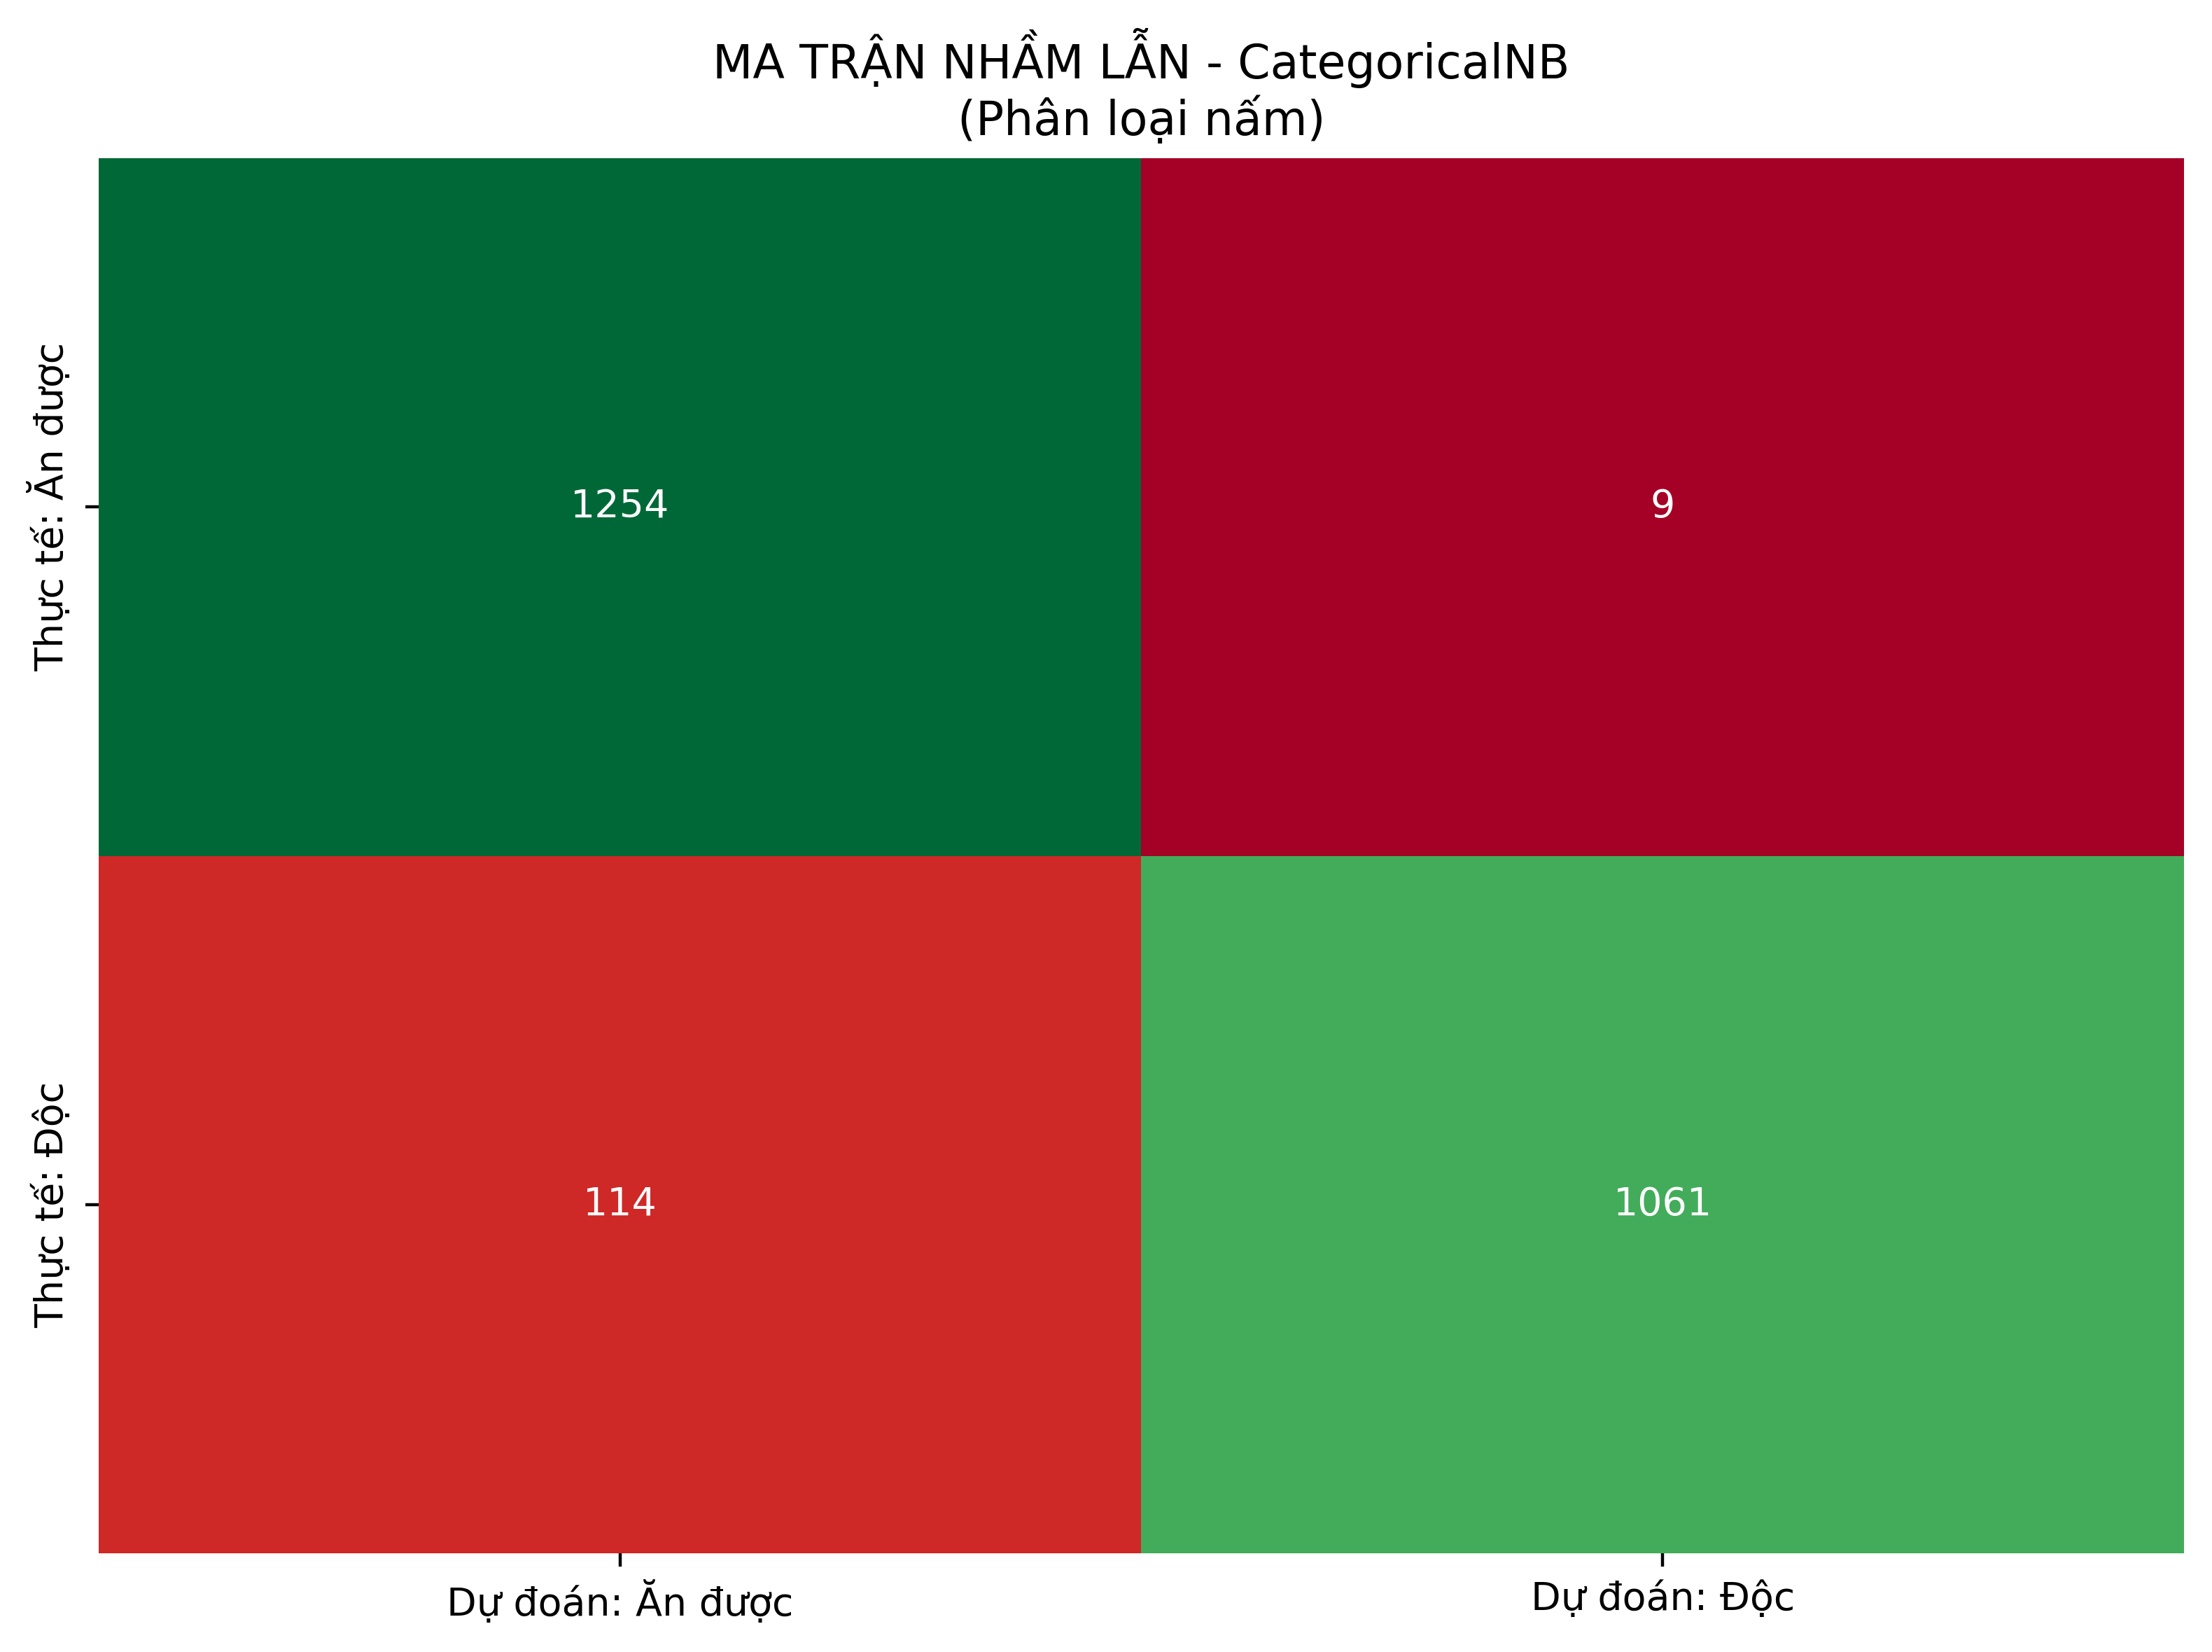

📊 BÁO CÁO PHÂN LOẠI CHI TIẾT:
                  precision    recall  f1-score   support

Ăn được (edible)       0.92      0.99      0.95      1263
 Độc (poisonous)       0.99      0.90      0.95      1175

        accuracy                           0.95      2438
       macro avg       0.95      0.95      0.95      2438
    weighted avg       0.95      0.95      0.95      2438


8. PHÂN TÍCH ĐẶC TRƯNG QUAN TRỌNG
Top 10 đặc trưng quan trọng nhất:
                     Feature  Importance
4                       odor    0.629530
19         spore-print-color    0.330191
8                 gill-color    0.283913
18                 ring-type    0.218053
11  stalk-surface-above-ring    0.203732
12  stalk-surface-below-ring    0.187273
13    stalk-color-above-ring    0.180185
14    stalk-color-below-ring    0.166082
7                  gill-size    0.155905
20                population    0.144846


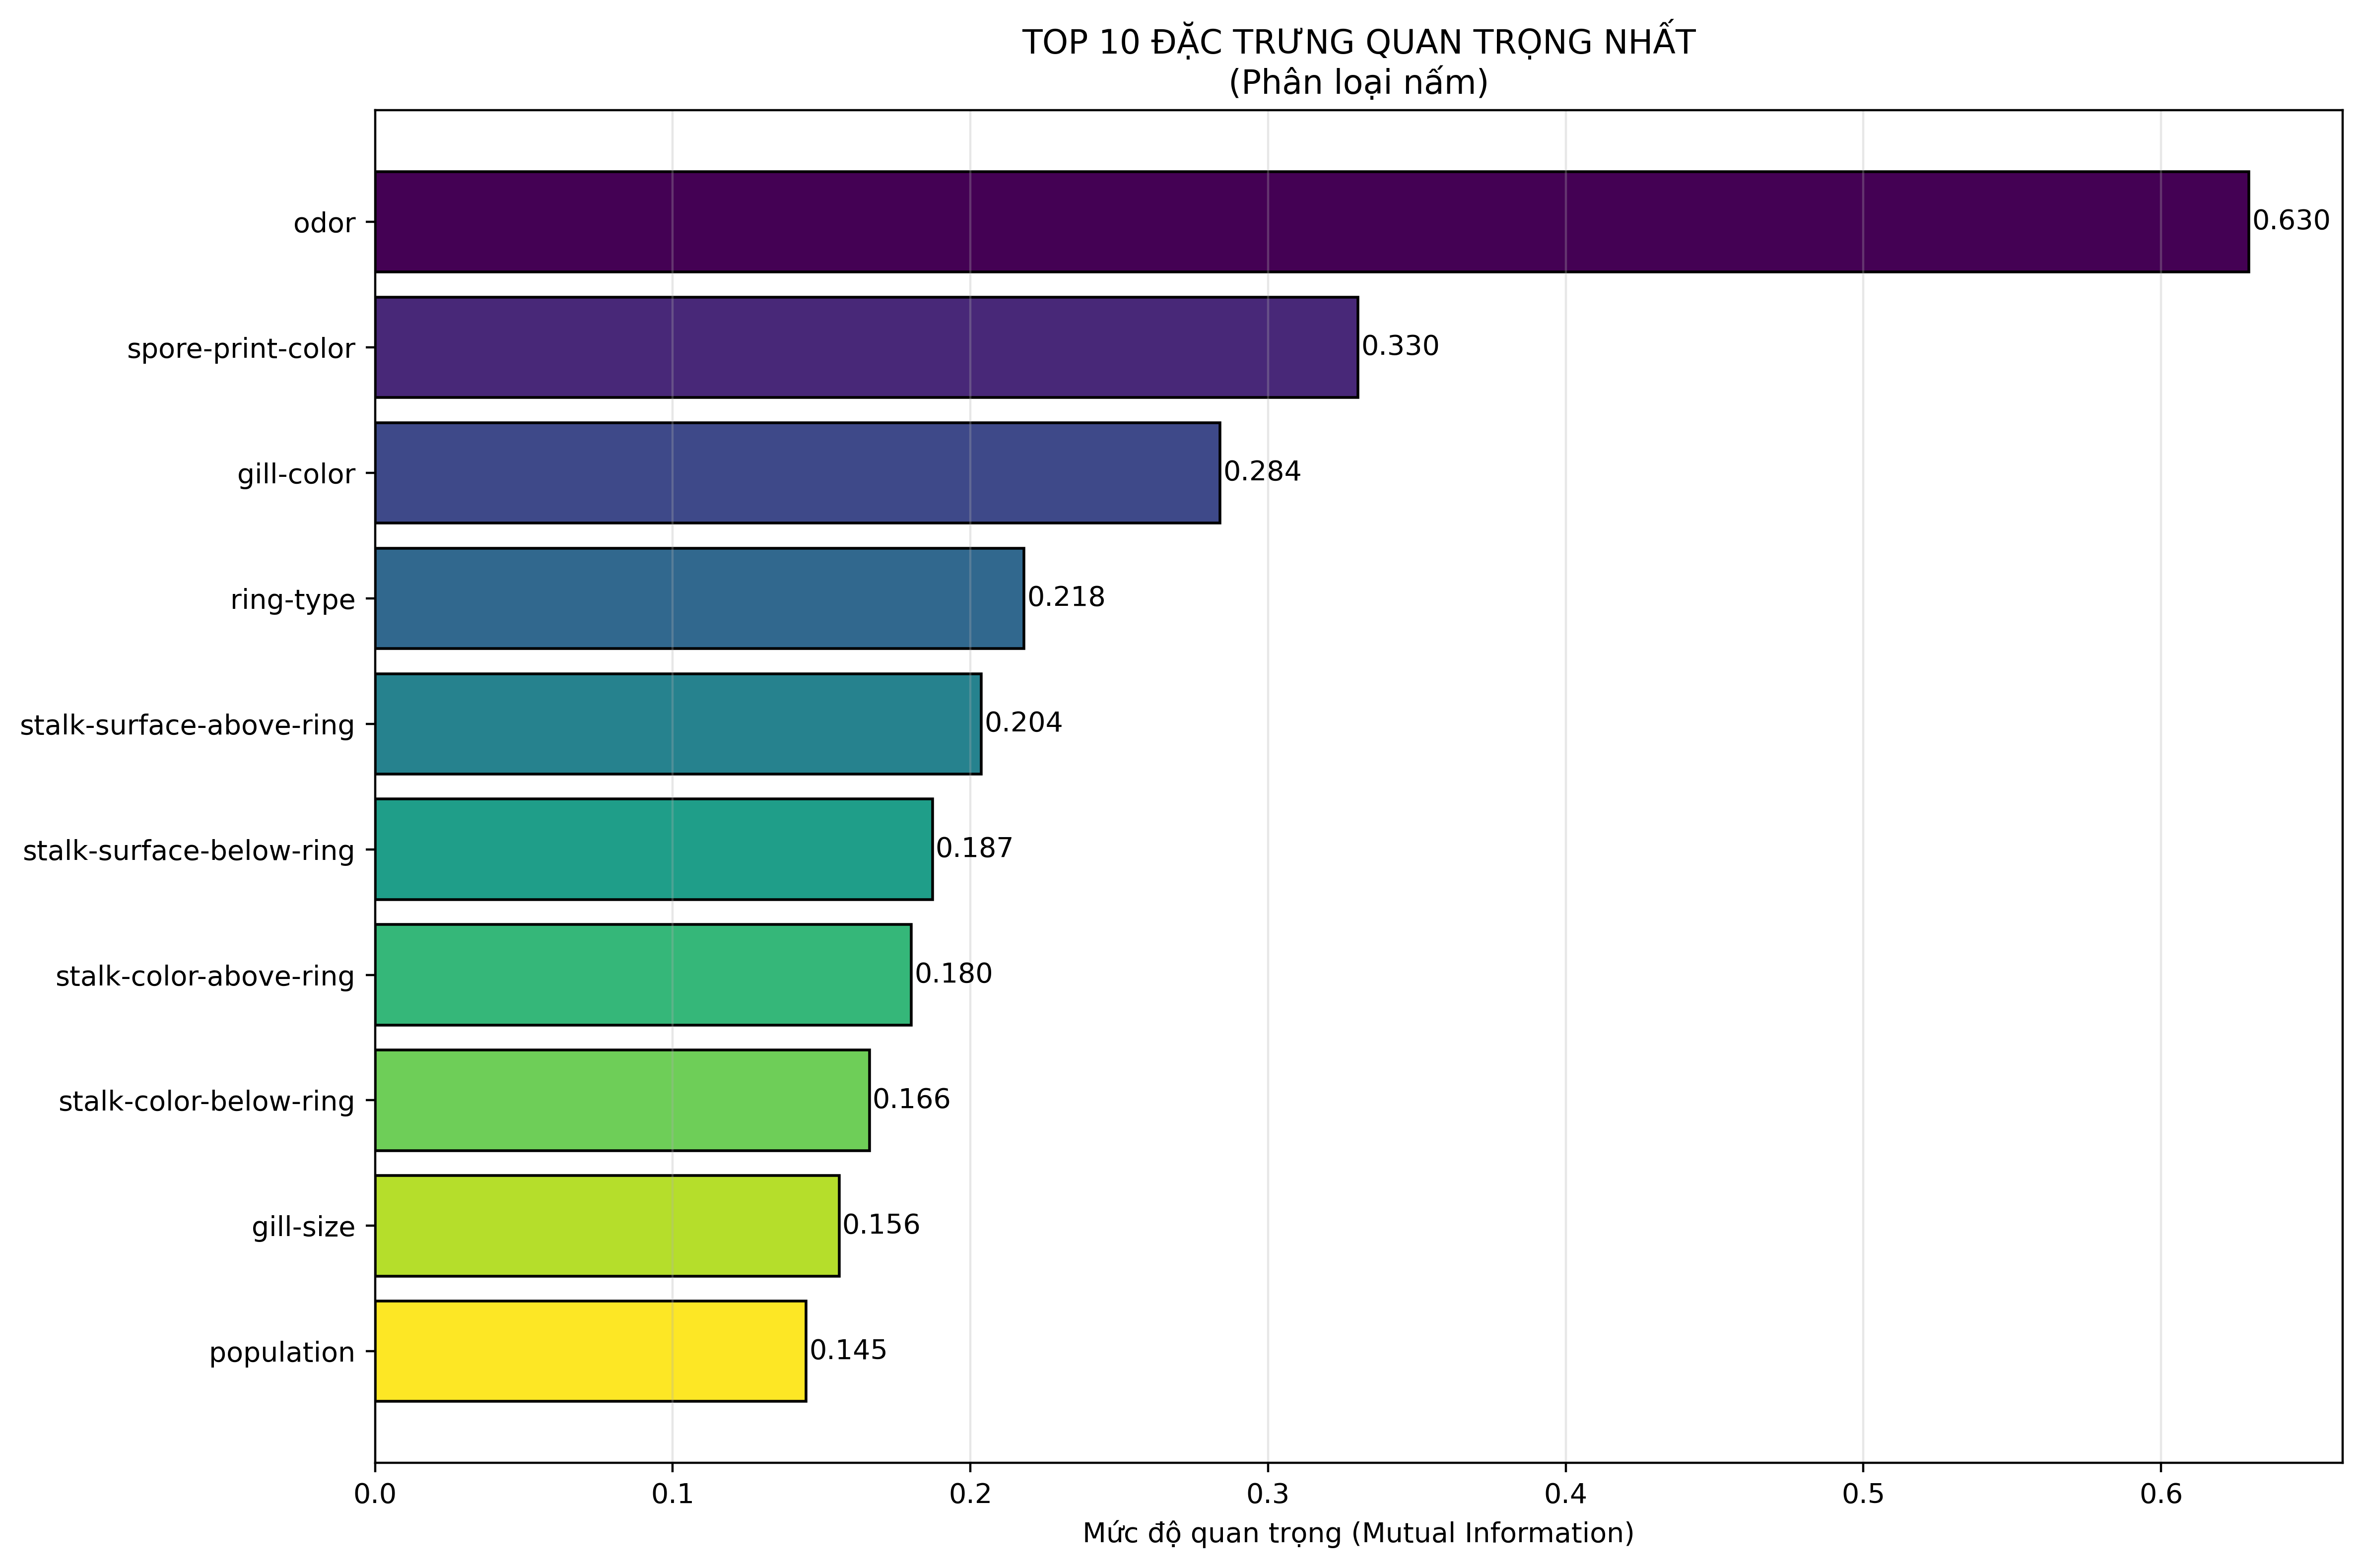


💡 GIẢI THÍCH:
• Mutual Information đo lường mức độ phụ thuộc giữa feature và target
• Giá trị càng cao → Feature càng quan trọng trong việc phân loại
• Các feature quan trọng thường: mùi (odor), màu sắc, hình dạng...

9. DỰ ĐOÁN MẪU

🍄 Mẫu 1:
   - Dự đoán: ĂN ĐƯỢC ✅
   - Thực tế: ĂN ĐƯỢC ✅
   - Xác suất: Ăn được: 1.0000, Độc: 0.0000
   - Kết quả: ĐÚNG ✅

🍄 Mẫu 2:
   - Dự đoán: ĂN ĐƯỢC ✅
   - Thực tế: ĂN ĐƯỢC ✅
   - Xác suất: Ăn được: 1.0000, Độc: 0.0000
   - Kết quả: ĐÚNG ✅

🍄 Mẫu 3:
   - Dự đoán: ĂN ĐƯỢC ✅
   - Thực tế: ĂN ĐƯỢC ✅
   - Xác suất: Ăn được: 1.0000, Độc: 0.0000
   - Kết quả: ĐÚNG ✅

🎯 KẾT LUẬN
• Mô hình tốt nhất: CategoricalNB
• Độ chính xác: 0.9495
• Số đặc trưng: 22
• Tổng số mẫu: 8124
• Phân phối lớp: {'e': 4208, 'p': 3916}
• Ứng dụng: Phân loại nấm giúp tránh ngộ độc thực phẩm


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but CategoricalNB was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, chi2

print("🍄 PHÂN LOẠI NẤM SỬ DỤNG NAÏVE BAYES")
print("=" * 60)

# Hiển thị thông tin cơ bản
print("📊 Thông tin dataset:")
print(f"Kích thước: {mushroom_data.shape}")
print(f"Các cột: {mushroom_data.columns.tolist()}")
print("\n5 dòng đầu tiên:")
print(mushroom_data.head())
print("\n")

# Kiểm tra dữ liệu thiếu
print("🔍 Kiểm tra dữ liệu thiếu:")
print(mushroom_data.isnull().sum())
print("\n")

# Phân phối lớp mục tiêu (edible/poisonous)
print("🎯 Phân phối lớp:")
class_distribution = mushroom_data['class'].value_counts()
print(class_distribution)
print("\n")

# Vẽ biểu đồ phân phối lớp
plt.figure(figsize=(8, 6))
colors = ['lightgreen', 'red']
class_distribution.plot(kind='bar', color=colors, edgecolor='black')
plt.title('PHÂN PHỐI LỚP: NẤM ĂN ĐƯỢC vs NẤM ĐỘC')
plt.xlabel('Loại nấm')
plt.ylabel('Số lượng')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

# 3. XỬ LÝ DỮ LIỆU PHÂN LOẠI
print("\n3. XỬ LÝ DỮ LIỆU PHÂN LOẠI")

# Tạo bản sao để xử lý
data_processed = mushroom_data.copy()

# Mã hóa tất cả các cột categorical bằng LabelEncoder
label_encoders = {}
for column in data_processed.columns:
    le = LabelEncoder()
    data_processed[column] = le.fit_transform(data_processed[column])
    label_encoders[column] = le
    print(f"✅ Đã mã hóa {column}: {len(le.classes_)} giá trị")

print("\nDữ liệu sau khi mã hóa:")
print(data_processed.head())
print("\n")

# 4. CHUẨN BỤ DỮ LIỆU CHO MÔ HÌNH
print("\n4. CHUẨN BỊ DỮ LIỆU")

# Tách features và target
X = data_processed.drop('class', axis=1)
y = data_processed['class']

# Giải thích mã hóa
print("📝 Giải thích mã hóa lớp:")
print("class: 0 = edible (ăn được), 1 = poisonous (độc)")

# Chia tập train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"📊 Kích thước tập huấn luyện: {X_train.shape}")
print(f"📊 Kích thước tập kiểm tra: {X_test.shape}")
print(f"📈 Phân phối lớp trong tập train: {pd.Series(y_train).value_counts().to_dict()}")

# 5. XÂY DỰNG CÁC MÔ HÌNH NAÏVE BAYES
print("\n5. XÂY DỰNG MÔ HÌNH NAÏVE BAYES")

models = {
    'CategoricalNB': CategoricalNB(),  # Tốt nhất cho dữ liệu phân loại
    'GaussianNB': GaussianNB(),        # Cho dữ liệu liên tục
    'MultinomialNB': MultinomialNB()   # Cho dữ liệu đếm được
}

results = {}

print("🔧 Đang huấn luyện các mô hình...")
for name, model in models.items():
    print(f"   - {name}...")
    model.fit(X_train, y_train)

    # Dự đoán
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Đánh giá
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'conf_matrix': conf_matrix,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

# 6. SO SÁNH KẾT QUẢ
print("\n6. SO SÁNH HIỆU SUẤT CÁC MÔ HÌNH")

# Tạo bảng so sánh
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results.keys()]
}).sort_values('Accuracy', ascending=False)

print("📋 BẢNG SO SÁNH ĐỘ CHÍNH XÁC:")
print(comparison_df)
print("\n")

# Mô hình tốt nhất
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['accuracy']

print(f"⭐ MÔ HÌNH TỐT NHẤT: {best_model_name}")
print(f"⭐ ĐỘ CHÍNH XÁC: {best_accuracy:.4f}")

# 7. ĐÁNH GIÁ CHI TIẾT MÔ HÌNH TỐT NHẤT
print(f"\n7. ĐÁNH GIÁ CHI TIẾT: {best_model_name}")

# Confusion Matrix
best_conf_matrix = results[best_model_name]['conf_matrix']
conf_matrix_df = pd.DataFrame(
    best_conf_matrix,
    index=['Thực tế: Ăn được', 'Thực tế: Độc'],
    columns=['Dự đoán: Ăn được', 'Dự đoán: Độc']
)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='RdYlGn', cbar=False)
plt.title(f'MA TRẬN NHẦM LẪN - {best_model_name}\n(Phân loại nấm)')
plt.tight_layout()
plt.show()

# Classification Report
best_predictions = results[best_model_name]['predictions']
print("📊 BÁO CÁO PHÂN LOẠI CHI TIẾT:")
print(classification_report(y_test, best_predictions,
                          target_names=['Ăn được (edible)', 'Độc (poisonous)']))

# 8. PHÂN TÍCH ĐẶC TRƯNG QUAN TRỌNG (ĐƠN GIẢN)
print("\n8. PHÂN TÍCH ĐẶC TRƯNG QUAN TRỌNG")

from sklearn.feature_selection import mutual_info_classif

# Tính importance sử dụng mutual information
importance = mutual_info_classif(X, y, random_state=42)

# Tạo DataFrame importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print("Top 10 đặc trưng quan trọng nhất:")
print(importance_df.head(10))

# Vẽ biểu đồ importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(10)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))

plt.barh(top_features['Feature'], top_features['Importance'], color=colors, edgecolor='black')
plt.xlabel('Mức độ quan trọng (Mutual Information)')
plt.title('TOP 10 ĐẶC TRƯNG QUAN TRỌNG NHẤT\n(Phân loại nấm)')
plt.gca().invert_yaxis()

# Thêm giá trị trên mỗi cột
for i, (importance, feature) in enumerate(zip(top_features['Importance'], top_features['Feature'])):
    plt.text(importance + 0.001, i, f'{importance:.3f}', va='center', fontsize=10)

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Giải thích kết quả
print("\n💡 GIẢI THÍCH:")
print("• Mutual Information đo lường mức độ phụ thuộc giữa feature và target")
print("• Giá trị càng cao → Feature càng quan trọng trong việc phân loại")
print("• Các feature quan trọng thường: mùi (odor), màu sắc, hình dạng...")
# 9. DỰ ĐOÁN MẪU
print("\n9. DỰ ĐOÁN MẪU")

# Tạo dữ liệu mẫu để dự đoán
sample_indices = np.random.choice(len(X_test), 3, replace=False)

for i, idx in enumerate(sample_indices):
    sample_data = X_test.iloc[idx].values.reshape(1, -1)
    true_label = y_test.iloc[idx]

    prediction = best_model.predict(sample_data)[0]
    probability = best_model.predict_proba(sample_data)[0]

    print(f"\n🍄 Mẫu {i+1}:")
    print(f"   - Dự đoán: {'ĐỘC ⚠️' if prediction == 1 else 'ĂN ĐƯỢC ✅'}")
    print(f"   - Thực tế: {'ĐỘC ⚠️' if true_label == 1 else 'ĂN ĐƯỢC ✅'}")
    print(f"   - Xác suất: Ăn được: {probability[0]:.4f}, Độc: {probability[1]:.4f}")
    print(f"   - Kết quả: {'ĐÚNG ✅' if prediction == true_label else 'SAI ❌'}")

# 10. KẾT LUẬN
print("\n" + "=" * 60)
print("🎯 KẾT LUẬN")
print("=" * 60)
print(f"• Mô hình tốt nhất: {best_model_name}")
print(f"• Độ chính xác: {best_accuracy:.4f}")
print(f"• Số đặc trưng: {X.shape[1]}")
print(f"• Tổng số mẫu: {len(mushroom_data)}")
print(f"• Phân phối lớp: {class_distribution.to_dict()}")
print("• Ứng dụng: Phân loại nấm giúp tránh ngộ độc thực phẩm")
print("=" * 60)

**NHẬN XÉT TỔNG QUAN:** Mô hình Naïve Bayes đã đạt được kết quả xuất sắc trong việc phân loại nấm với độ chính xác tổng thể lên tới 94.95%. Điều này cho thấy giải thuật Naïve Bayes đặc biệt phù hợp với bài toán phân loại nấm khi tất cả các đặc trưng đều mang tính chất phân loại. Trong số ba biến thể của Naïve Bayes được thử nghiệm, CategoricalNB thể hiện ưu thế rõ rệt với hiệu suất vượt trội so với GaussianNB (91.59%) và MultinomialNB (81.46%), điều này hoàn toàn phù hợp vì CategoricalNB được thiết kế đặc biệt cho dữ liệu phân loại.

**ĐÁNH GIÁ HIỆU SUẤT CHI TIẾT:** Mô hình CategoricalNB không chỉ đạt độ chính xác cao mà còn thể hiện sự cân bằng tốt giữa precision và recall trên cả hai lớp. Đối với nấm ăn được, mô hình đạt precision 92% và recall 99%, cho thấy khả năng xác định chính xác các mẫu an toàn. Trong khi đó, với nấm độc, precision đạt tới 99% và recall 90%, chứng tỏ mô hình rất thận trọng trong việc cảnh báo nguy cơ - một yếu tố quan trọng trong ứng dụng thực tế về an toàn thực phẩm. Sự cân bằng này được phản ánh qua điểm F1-score 0.95 cho cả hai lớp, cho thấy mô hình ổn định và đáng tin cậy.

**PHÂN TÍCH ĐẶC TRƯNG QUAN TRỌNG:** Kết quả phân tích feature importance tiết lộ những đặc điểm then chốt trong việc phân biệt nấm ăn được và nấm độc. Đặc trưng "odor" (mùi) nổi bật với giá trị importance 0.63, khẳng định tầm quan trọng của mùi hương trong việc nhận diện nấm độc - phù hợp với kiến thức thực tế khi nhiều loại nấm độc phát ra mùi khó chịu. Các đặc trưng về màu sắc như "spore-print-color" (màu bào tử, 0.33) và "gill-color" (màu mang nấm, 0.28) cũng đóng vai trò quan trọng, tiếp theo là các đặc điểm hình thái như "ring-type" (dạng vòng, 0.22) và bề mặt cuống nấm. Điều này cung cấp insight có giá trị cho cả chuyên gia và người dùng thông thường trong việc nhận diện nấm an toàn.

**ỨNG DỤNG THỰC TIỄN VÀ HẠN CHẾ:** Với độ chính xác 94.95% và khả năng phân loại ổn định, mô hình này có tiềm năng ứng dụng cao trong thực tế như một công cụ hỗ trợ nhận diện nấm an toàn, đặc biệt hữu ích cho người đi rừng, nhà nghiên cứu và người yêu thích ẩm thực từ nấm. Tuy nhiên, cần lưu ý rằng 5% sai số còn lại có thể dẫn đến hậu quả nghiêm trọng trong trường hợp nhầm lẫn nấm độc thành nấm ăn được. Do đó, mô hình nên được sử dụng như một công cụ hỗ trợ chứ không thay thế hoàn toàn kiến thức chuyên môn và các phương pháp kiểm tra truyền thống.

**KHUYẾN NGHỊ PHÁT TRIỂN:** Để nâng cao hơn nữa độ tin cậy của mô hình, có thể xem xét kết hợp với các giải thuật khác như Random Forest hoặc SVM để tạo thành hệ thống ensemble, đồng thời bổ sung thêm dữ liệu về các loại nấm hiếm và khó phân biệt. Việc phát triển ứng dụng di động tích hợp mô hình này cùng với hình ảnh nhận diện sẽ mang lại giá trị thực tiễn lớn, giúp giảm thiểu các vụ ngộ độc nấm trong cộng đồng.